# Differential Expression Analysis - RhithroLoxo

## Set-up

If you've already saved the workspace image from a previous session, jupyter should automatically reload it. You may need to reload the packages though. The .RData file is not on GitHub, so you will have to actually run it the first time through. 

First, make sure you're actually running this from a compute node, not the login. On Poseidon, logins are 'l1' and 'l2', whereas all other nodes start with 'pn'.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn140" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Now load in the packages. Specify number of cores you requested for SLURM interactive session under `register(MulticoreParam())`

In [2]:
require(DESeq2)
require(ggplot2)
require(apeglm)
require(ashr)
library("BiocParallel")
register(MulticoreParam(12))
require(VennDiagram)
require(RColorBrewer)
require(pheatmap)

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching p

## Data import

Now import the count data, rounding decimals to integers.

In [3]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)

Take a look.

In [4]:
head(all_counts)
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,156,46,69,43,68,...,80,51,80,84,55,56,63,66,69,39
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0,0,2,0,2,...,0,0,1,0,0,2,1,5,2,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,0,1,9,5,7,...,18,7,10,2,2,3,7,10,7,6
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0,0,1,0,2,...,2,1,2,0,0,0,2,3,1,2
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,3,0,1,1,0,...,3,3,0,1,1,0,3,0,4,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 149511     83

Read in the sample metadata and have a look.

In [5]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_C_6,AP,C,Native,M


[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [6]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

## Filtering

Okay here I am just going to calculate the normalized counts so I can try to identify transcripts whose highest representation occurs in the Loxo libraries. This is because there appears to be some latent contamination, either from index hopping or basal levels infection in otherwise "uninfected" crabs. This shows up downstream in some crazily overexpressed transcripts in the parasitized individuals, which appear not to be an actual response, but rather just contamination with parasite mRNA. This might not help completely because of tissue specific expression in the parasite (libraries made from externae, while contamination from internal, root-system tissues), but worth a shot. At least to strengthen the case for removal by thresholding later. 

The infected crabs will be excluded from this comparison. Because of tissue specific expression in the parasite, the highest expression of some contaminant transcripts may be expected in the infected crab libraries rather than those of the parasite itself. Thus, we are just looking for transcripts that are more highly represented in the parasite libraries than the control crab libraries.

Create a DESeq dataset just for the purpose of calculating normalized counts

In [7]:
contam <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition )

converting counts to integer mode


Estimate size factors and save normalized counts to object 'norm_mat'

In [8]:
contam <- estimateSizeFactors(contam)
norm_mat <- counts(contam, normalized=TRUE)

First let's remove the parasitized crabs. This includes all samples with the naming pattern `*_P_*`. The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [9]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

In [10]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in norm_mat_sub are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior. Parasite samples follow the naming pattern `*_F_*`.

In [11]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
contam_subset[1:20,18:29]

,LA_C_8,LA_F_1,MA_C_1,MA_C_2,MA_C_4,MD_C_10,MD_C_11,MD_C_1,MD_C_4,MD_C_7,MD_F_4,ML_C_10
TRINITY_DN130836_c0_g1_i1,8.342821,4515.9519,5.394225,1.521581,5.038778,5.136595,4.485368,4.048551,5.319531,4.6419802,729.6896,2.551833
TRINITY_DN6090_c0_g1_i1,114.018547,0.0000,149.959461,164.330783,157.461801,181.493023,146.522028,222.670320,189.729921,180.6152294,364.8448,146.305106
TRINITY_DN27882_c0_g1_i1,9.733291,694.7618,15.103831,10.651069,5.038778,14.553686,7.475614,14.169929,11.525649,9.2839604,0.0000,10.207333
TRINITY_DN33032_c0_g1_i1,8.342821,694.7618,6.473070,9.129488,10.077555,9.417091,5.232930,6.072827,5.319531,5.9079748,729.6896,18.713444
TRINITY_DN815_c0_g2_i2,241.246561,0.0000,189.876728,313.445753,311.144519,116.429487,217.540358,204.451839,134.761439,316.9206478,364.8448,281.552268
TRINITY_DN12072_c0_g1_i2,261.408377,694.7618,126.224870,176.503434,238.082243,173.788131,299.024547,118.757504,238.492284,166.2672906,1094.5344,249.229046
TRINITY_DN131921_c0_g1_i1,56.314039,347.3809,53.942252,53.255346,23.934194,84.753817,79.989066,103.238057,57.628247,80.1796579,0.0000,83.359886
TRINITY_DN29174_c0_g1_i1,72.999680,347.3809,93.859519,80.643810,119.670969,63.351338,78.493944,95.140955,58.514836,142.2133932,0.0000,85.061108
TRINITY_DN39441_c0_g1_i1,25.723697,0.0000,43.153802,34.996371,22.674499,35.956165,38.873191,22.267032,32.803771,13.0819442,729.6896,143.753273
TRINITY_DN26877_c0_g1_i1,26.418932,694.7618,7.551915,4.564744,11.337250,24.826876,32.892700,18.218481,25.711064,16.4579298,0.0000,15.310999


Scrolling through, it's clear that these transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. Interestingly, oftentimes even when the highest value is in a parasite column, the other parasite column has a value of zero. I am not quite sure what this could mean. Different expression patterns between the two parasite externae, with both ending up in the Rhithro assembly? 

Okay now I'm going to save the rownames for use later:

In [12]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5797

There are 5797 transcripts that have higher expression in a parasite sample than any of the "clean" samples. It's a large number, but relative to the ~150K transcripts, not really.

I am now going to remove the Loxo samples from the raw expression matrix and sample metadata, and make another DESeq dataset object. 

In [13]:
all_counts <- all_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

Verify again that the counts and metadata match up:

In [14]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay let's get started. This part of the analysis is just going to do a base comparison between uninfected and parasitized.

In [15]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [16]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 12 workers


Let's visualize the data using some PCAs. This will be helpful for identifying sample outliers.

First we'll apply a variance stabilizing transformation to our normalized counts. 

In [17]:
vsd <- vst(dds, blind=FALSE)

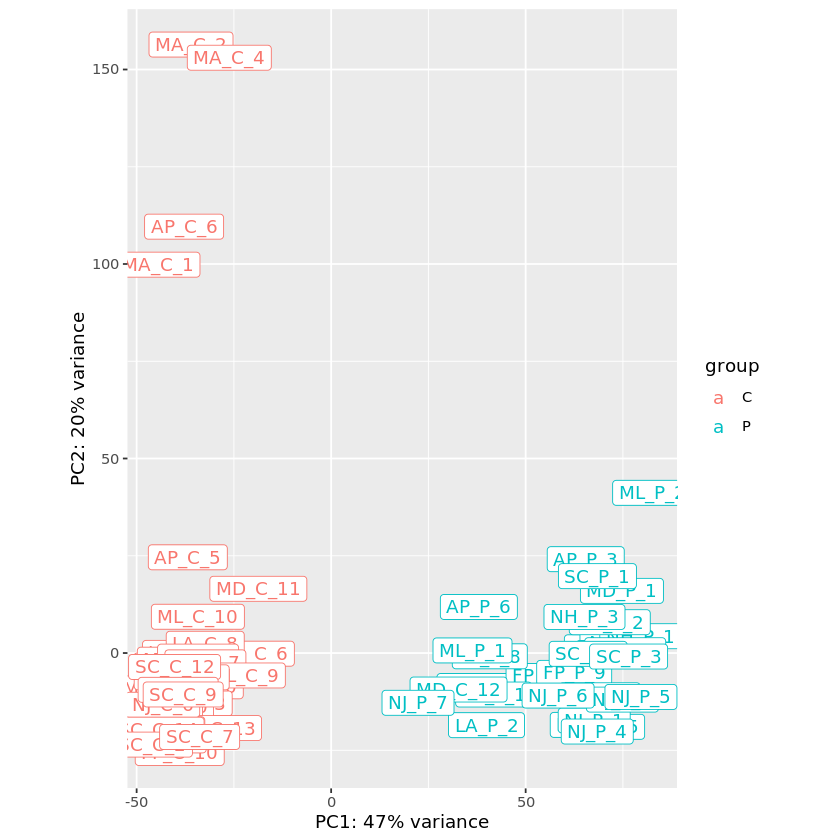

In [18]:
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see that PCA 1 clearly separates the sample according to infection status (whether this is due to a crab response or contamination from parasite remains to be seen...). Along the second PCA axis, you can see four extreme outlier at the upper left corner. Let's investigate this a little more closely by looking at the expression of particular high variance transcripts. 

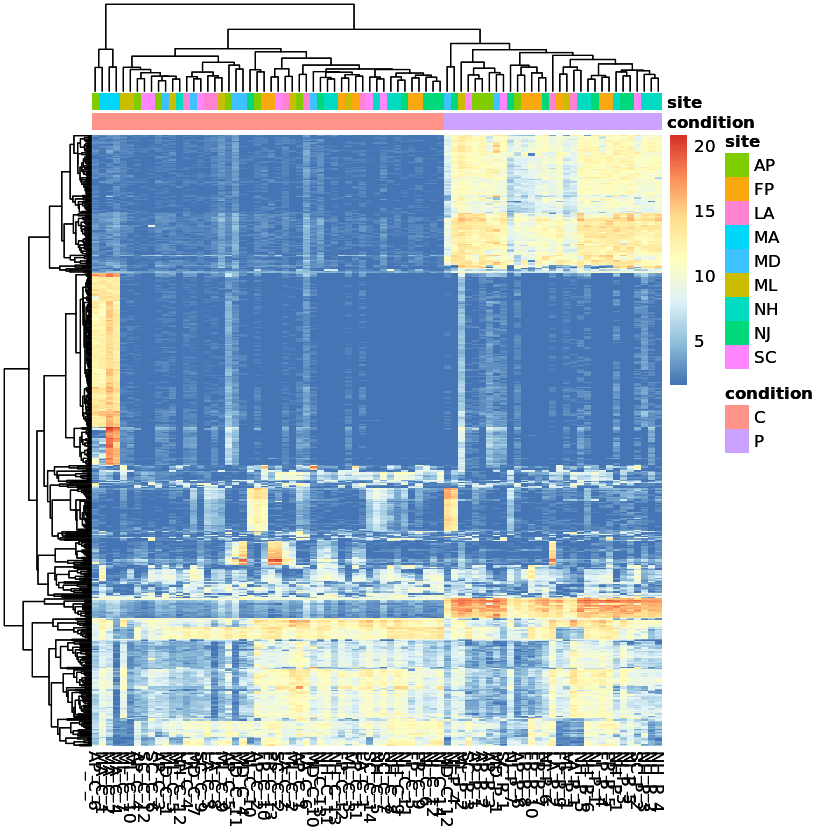

In [19]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 500)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap <- pheatmap(vsd_df[topVarGenes,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap

Looking at the top 500 highest variance transcripts, you can see that the transcript cluster second from the top separates samples in the same way as PCA axis 2 from above, with MA_C_1, MA_C_2, MA_C_4, and AP_C_6 having really high expression. Let's figure out what those are. 

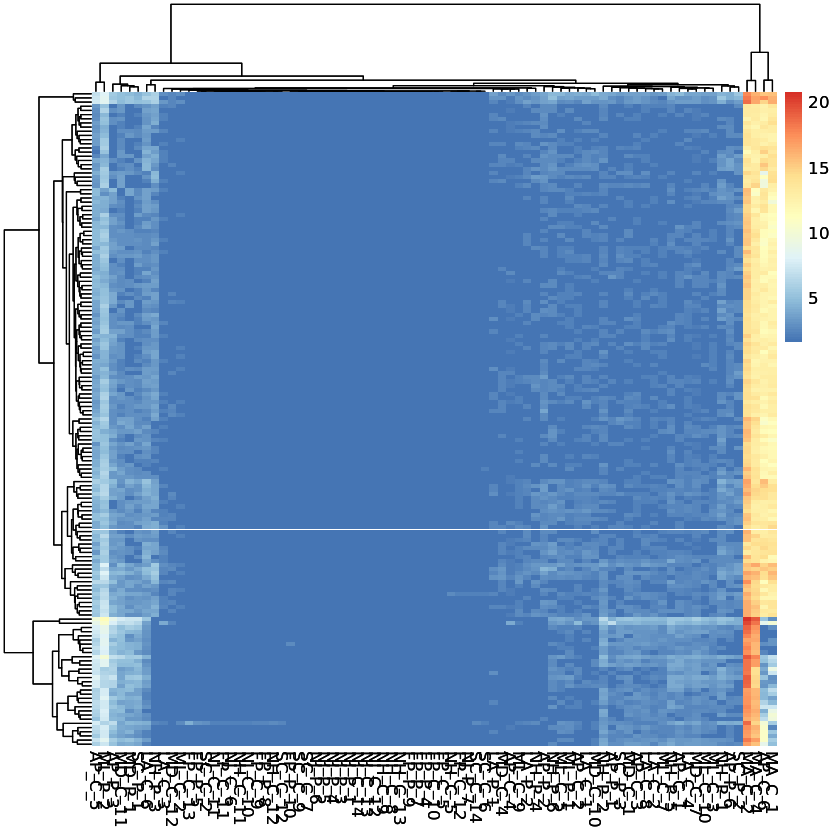

In [20]:
idx <- sort(cutree(heatmap$tree_row, k=10)) #separate transcripts by cluster assignment
idx <- names(which(idx==6)) #after searching, cluster 6 is the one with the transcripts we want
heatmap <- pheatmap(vsd_df[idx,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)
heatmap

Okay now we found the cluster that has all of these transcripts. Let's get the names and search annotations. Load in annotations.

In [21]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="", stringsAsFactors = FALSE)

In [22]:
outlier_annot <- annot[annot[,1] %in% rownames(vsd[idx,]),] #get matching annotations
head(outlier_annot[order(outlier_annot[,11]),c(1,2,3,11,12,13,14)], 20) #show results

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
10388,TRINITY_DN93898_c0_g1_i1,CEO94640.1,68.4,3.7e-291,95.0,CEO94640.1 hypothetical protein PBRA_000425 [Plasmodiophora brassicae],plasmodiophora brassicae
15124,TRINITY_DN764_c0_g1_i1,sp|P49951|CLH1_BOVIN,32.7,5.5e-270,92.0,sp|P49951|CLH1_BOVIN Clathrin heavy chain 1 OS=Bos taurus OX=9913 GN=CLTC PE=1 SV=1,bos taurus
13216,TRINITY_DN3369_c0_g1_i1,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS,47.1,2.7e-228,93.9,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS Piwi-like protein 4 (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
4980,TRINITY_DN11670_c0_g1_i10,XP_013782023.2,38.0,1.3e-216,78.8,XP_013782023.2 U5 small nuclear ribonucleoprotein 200 kDa helicase-like [Limulus polyphemus],limulus polyphemus
9088,TRINITY_DN4882_c0_g1_i1,sp|O02192|HSP83_DROAV,55.1,1.9e-192,94.9,sp|O02192|HSP83_DROAV Heat shock protein 83 OS=Drosophila auraria OX=47315 GN=Hsp83 PE=3 SV=1,drosophila auraria
3706,TRINITY_DN3073_c0_g1_i4,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS,55.6,3.7e-180,87.1,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS Glucose regulated protein 78 OS=Macrobrachium rosenbergii OX=79674 GN=GRP78 PE=2 SV=1,macrobrachium rosenbergii
12080,TRINITY_DN129176_c0_g1_i1,XP_018497583.1,36.6,5.6e-180,96.7,XP_018497583.1 probable phospholipid-transporting ATPase IIA [Galendromus occidentalis],galendromus occidentalis
16390,TRINITY_DN9317_c0_g1_i1,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS,57.6,9.5e-172,81.6,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS Lysine--tRNA ligase (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
14890,TRINITY_DN9382_c0_g1_i1,Q42971.2,68.2,1.4e-170,93.8,Q42971.2 RecName: Full=Enolase; AltName: Full=2-phospho-D-glycerate hydro-lyase; AltName: Full=2-phosphoglycerate dehydratase; AltName: Full=OSE1,
10602,TRINITY_DN2622_c0_g1_i2,tr|L1J5W8|L1J5W8_GUITC,65.1,8.6e-158,78.6,tr|L1J5W8|L1J5W8_GUITC Adenosylhomocysteinase OS=Guillardia theta (strain CCMP2712) OX=905079 GN=GUITHDRAFT_110013 PE=3 SV=1,guillardia theta (strain ccmp2712)


There doesn't seem to be anything special about these transcripts, though it's hard to tell just from the reference IDs. I will dig into this a bit more later. It is likely they reflect some other process in the crab, such as molting, both Carolyn and I previously observed in earlier explorations of the data...

Either way, I am going to remove these outlier samples. They are contributing too much variation and will present issues when trying to fit the DESeq2 models and cause issues with count normalization. 

In [23]:
all_counts <- all_counts[,!(colnames(all_counts) %in% c("MA_C_1","MA_C_2","MA_C_4","AP_C_6"))]
all_counts[1:6,1:6]
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_P_1
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,46
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,1
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,0


[1] 149511     77

Okay now you can see the four of them were removed. Now make sure the coldata matches.

In [24]:
coldata <- coldata[colnames(all_counts),]
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay good let's make another dds object.

In [25]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [26]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 12 workers


In [27]:
res <- results(dds, alpha=0.05)
summary(res)


out of 146756 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1587, 1.1%
LFC < 0 (down)     : 1655, 1.1%
outliers [1]       : 2527, 1.7%
low counts [2]     : 38896, 27%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here we see that there are 1587 transcripts deemed significantly upregulated in parasitized crabs, and 1655 significantly downregulated, according the the Wald test.

As mentioned earlier, it is my suspicion that some of these upregulated transcripts are contamination from Loxo. Let's have a look.

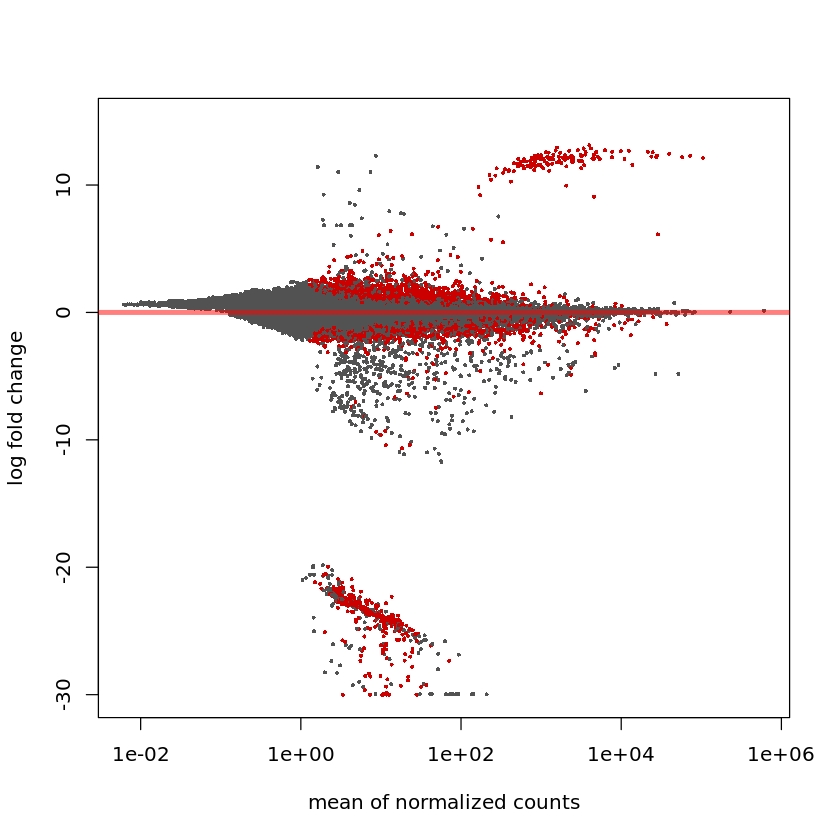

In [28]:
plotMA(res, ylim=c(-30,15))

Here we see the pattern I have alluded to, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

We also see a cloud of extremely underexpressed transcripts (<-20 LFC). I will deal with these after the Loxo contamination (but I can tell you now that these are contamination from trematodes and perhaps other parasites in three NH control crabs \[hence the lower count means\]).

Let's see if the OVERexpressed ones match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [29]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
head(res_sig)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN54766_c0_g2_i1,4011.288,13.12440,0.7753760,16.92650,2.869305e-64,2.361192e-61
TRINITY_DN57720_c0_g1_i1,1575.042,12.94254,0.4599292,28.14029,3.150942e-174,8.734162e-171
TRINITY_DN106284_c0_g1_i1,3395.123,12.86814,0.4786270,26.88552,3.243707e-159,5.256452e-156
TRINITY_DN81798_c0_g1_i1,4201.369,12.86527,0.5721788,22.48470,5.860082e-112,5.321207e-109
TRINITY_DN120239_c0_g1_i1,2870.503,12.72487,0.4728986,26.90824,1.759063e-159,2.895115e-156
TRINITY_DN114680_c0_g1_i1,6259.348,12.72382,0.4614713,27.57229,2.391955e-167,5.360677e-164


You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am not sure how they made it into the transcriptome. It's hard to think of a biological reason. I am thinking this is due to index hopping during sequencing. If there were parasitizied and unparasitized crabs on the same lane (there were), then even a small amount of index hopping could have led to parasite reads being built into the txm, either as chimeras with crab sequences or alone. 

I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 3242 significant transcripts, 1587 up and 1655 down. There were 5797 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [30]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

[1] 484

Okay so there are 484 transcripts that came up as significant that were also identified as potential contamination. Let's see what the distribution of LFCs look like for these transcripts.

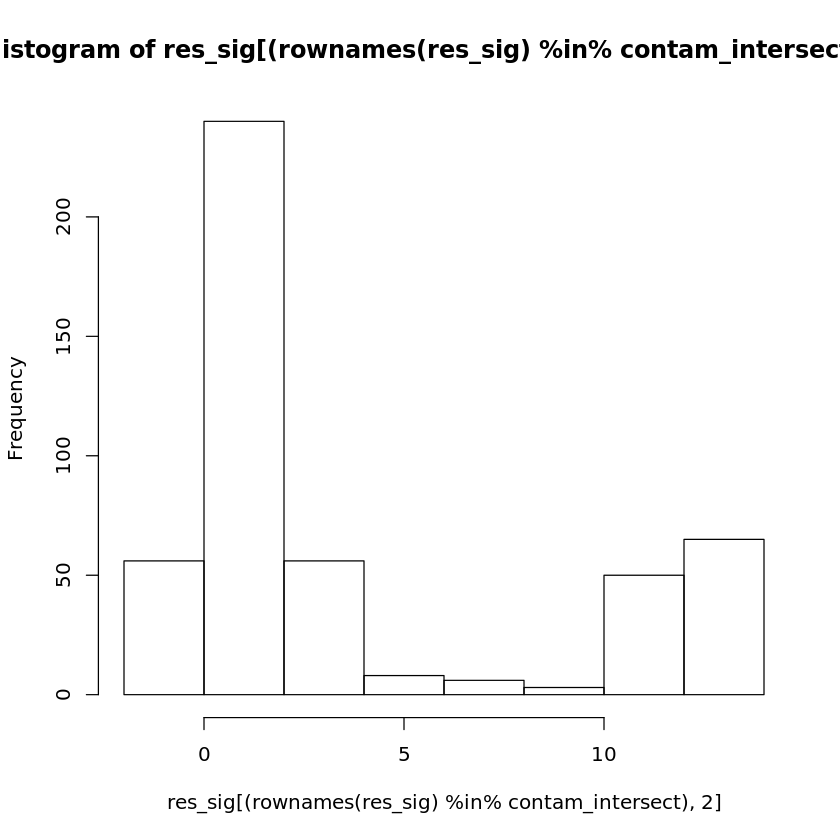

In [31]:
hist(res_sig[(rownames(res_sig) %in% contam_intersect),2])

It shows a bimodal pattern. Most of these transcripts are overexpressed, but a subset (~100) are extremely enriched. It is these that are most likely to be contamination. We will still consider all of these putative contamination and slate them for removal, as I believe it is more prudent to be liberal with what we discard.

 Let's take a look at the significant results table with the putative Loxo contaminants removed.

In [32]:
head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN94855_c0_g1_i1,818.242824,12.194390,0.4466536,27.301670,4.052334e-164,7.760809e-161
TRINITY_DN103226_c0_g1_i1,765.597664,12.155805,0.4838668,25.122213,2.844574e-139,3.366601e-136
TRINITY_DN121942_c0_g1_i1,730.919219,11.877771,0.4706129,25.238944,1.497841e-140,1.813473e-137
TRINITY_DN128205_c0_g1_i1,3066.964042,11.869844,0.4601489,25.795657,9.920000e-147,1.339620e-143
TRINITY_DN115787_c0_g1_i1,737.611108,11.578184,0.4608741,25.122227,2.843591e-139,3.366601e-136
TRINITY_DN122219_c0_g1_i1,615.855132,11.296783,0.4532567,24.923587,4.130268e-137,4.780808e-134
TRINITY_DN128046_c0_g1_i1,165.485629,9.851227,0.4250518,23.176530,7.854333e-119,7.257197e-116
TRINITY_DN146992_c0_g1_i1,5.882913,4.837203,0.8458548,5.718716,1.073323e-08,1.378735e-06
TRINITY_DN22600_c0_g1_i1,73.964123,4.524579,1.0450137,4.329684,1.493235e-05,1.093030e-03
TRINITY_DN51295_c0_g1_i1,18.506585,4.416180,0.6151665,7.178837,7.030708e-13,1.184905e-10


A lot of those transcripts are now removed. There are just around 7 of them left, depending on where you draw the line.

I am going to repeat visualization with all of putative Loxo contaminant transcripts removed. 

In [33]:
res2 <- results(subset(dds, !rownames(dds) %in% contam_IDs), alpha=0.05)

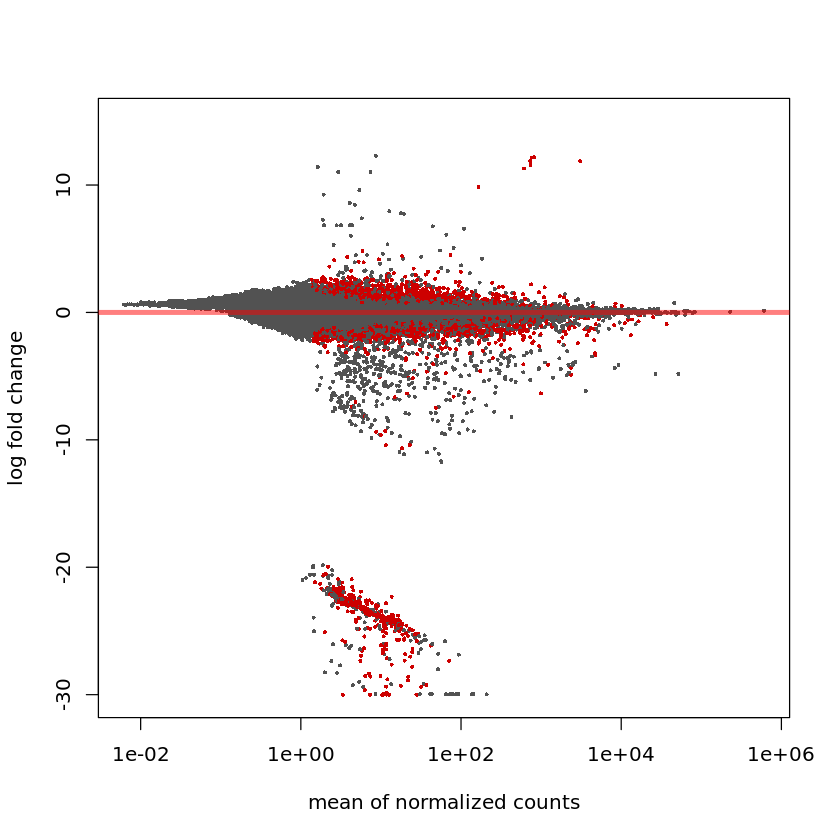

In [34]:
plotMA(res2, ylim=c(-30,15))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them by thresholding.

But first, let's look at the identity of the UNDERexpressed transcripts. Let's make a subset of the results without these transcripts, and then get the names of those transcripts. 

In [35]:
extra_under <- subset(res2, log2FoldChange < -15)
extra_under <- rownames(extra_under)
length(extra_under)

[1] 642

Now we'll make another vsd object and use the list of transcripts to plot just those that had extremely low LFCs.

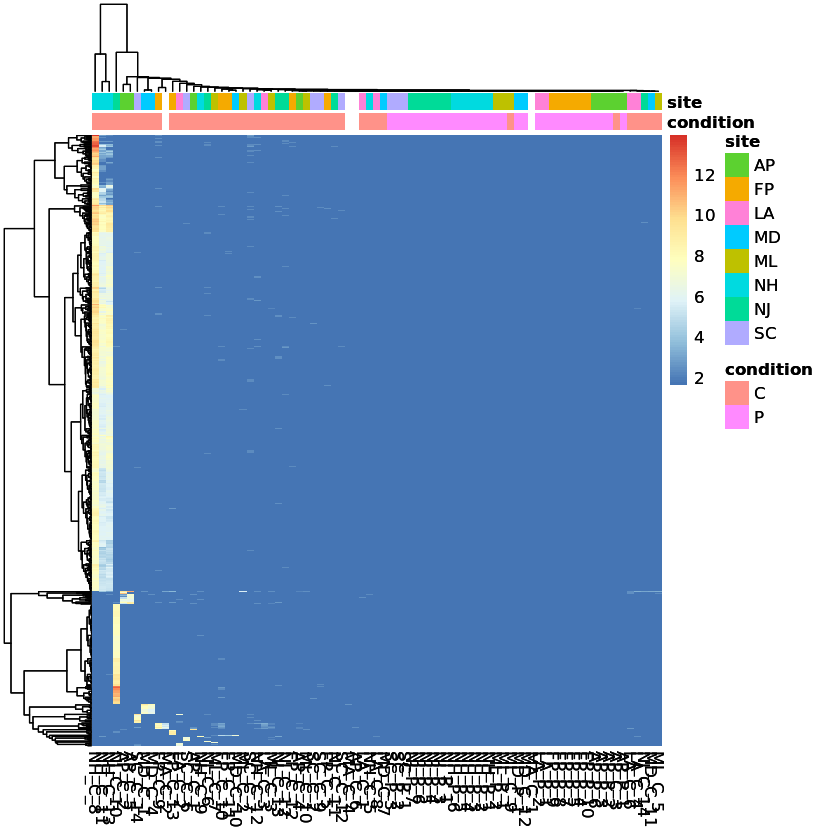

In [36]:
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd2 <- vst(dds, blind=TRUE)
vsd_df <- assay(vsd)
heatmap3 <- pheatmap(vsd_df[extra_under,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap3

It's clear that expression of these transcripts occurs in just a few crabs. It's difficult to see the sample names, but it is mostly in three control samples from NH (NH_C_8, NH_C_11, NH_C_13) and one from NJ (NJ_C_10). So these transcripts are only represented in a few samples. 

Let's use the annotations to figure out the identity of these transcripts.

In [37]:
low_annot <- annot[annot$Query.Sequence %in% extra_under,c(1,2,3,11,13,14)]
low_annot <- low_annot[order(low_annot$E.Value),]
low_annot

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Description,Species
7701,TRINITY_DN18400_c0_g1_i1,ORD95904.1,98.4,0.0e+00,ORD95904.1 hypothetical protein HERIO_2110 [Hepatospora eriocheir],hepatospora eriocheir
13067,TRINITY_DN145784_c0_g1_i1,THD18379.1,88.4,3.2e-220,THD18379.1 UDP-N-acetylglucosamine--peptide N-acetylglucosaminyltransferase 110 kDa subunit [Fasciola hepatica],fasciola hepatica
18633,TRINITY_DN110752_c0_g1_i1,sp|P79384|PCCB_PIG,75.5,1.6e-211,"sp|P79384|PCCB_PIG Propionyl-CoA carboxylase beta chain, mitochondrial OS=Sus scrofa OX=9823 GN=PCCB PE=1 SV=1",sus scrofa
17127,TRINITY_DN117850_c0_g1_i1,TNN17417.1,72.2,6.7e-201,TNN17417.1 Ubiquitin-like modifier-activating enzyme 1 isoform 2 [Schistosoma japonicum],schistosoma japonicum
8818,TRINITY_DN14648_c0_g1_i1,THD26774.1,77.3,8.3e-196,THD26774.1 Innexin [Fasciola hepatica],fasciola hepatica
6696,TRINITY_DN63237_c0_g1_i1,KAA3675984.1,87.1,1.3e-180,KAA3675984.1 phosphoglycerate kinase [Paragonimus westermani],paragonimus westermani
2582,TRINITY_DN145327_c0_g1_i1,KAA3680893.1,82.5,2.7e-180,KAA3680893.1 creatine kinase [Paragonimus westermani],paragonimus westermani
7687,TRINITY_DN28558_c0_g1_i2,tr|A0A075AIH6|A0A075AIH6_9TREM,85.5,3.3e-177,tr|A0A075AIH6|A0A075AIH6_9TREM Fructose-bisphosphate aldolase (Fragment) OS=Opisthorchis viverrini OX=6198 GN=T265_12938 PE=3 SV=1,opisthorchis viverrini
16713,TRINITY_DN28635_c0_g1_i1,GAA28380.1,83.5,3.0e-163,GAA28380.1 glyceraldehyde 3-phosphate dehydrogenase [Clonorchis sinensis],clonorchis sinensis
2249,TRINITY_DN63964_c0_g1_i1,sp|O18413|PRS8_DROME,91.6,1.4e-161,sp|O18413|PRS8_DROME 26S proteasome regulatory subunit 8 OS=Drosophila melanogaster OX=7227 GN=Rpt6 PE=1 SV=2,drosophila melanogaster


Looking through, it's clear that these represent contamination from a flatworm of some sort. Most if not all of the top matching hits are flatworms. There is also some Hepatospora, a fungal pathogen of crabs. 

Okay, now I am going to remove all of these transcripts, not just those that map because many are lacking annotation. For removing both the putative Loxo and flatworm contaminants, I am going to set a threshold of an absolute value of 8. Let's look and see what that would remove, after already having flagged the putative Loxo for removal.

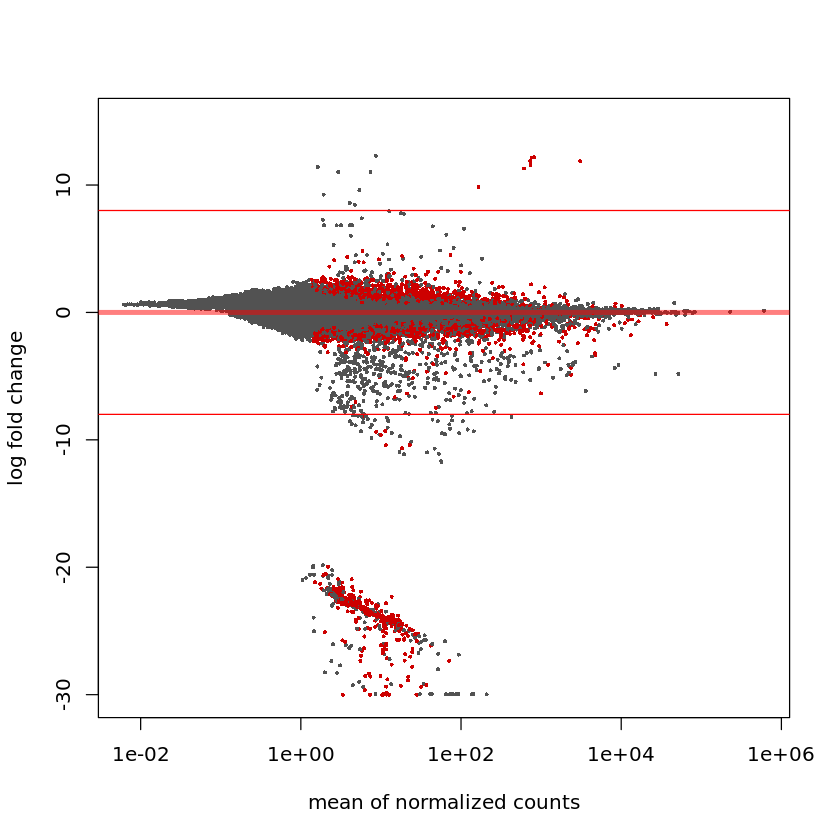

In [38]:
plotMA(res2, ylim=c(-30,15))
abline(h=8,col="red")
abline(h=-8,col="red")

Using 8 as a threshold would remove what I suspect to be lingering Loxo contamination at the top, and all of the putative flatworm contamination at the bottom. It will also remove a couple dozen transcripts closer towards the center. I think it is worth being liberal with what we throw out to ensure that the patterns we see in the data are reflective of crabs' responses to experimental Loxo infection instead of contamination from Loxo itself or other parasites. 

In [39]:
contam_high <- rownames(subset(res2, res2$log2FoldChange > 8))
contam_low <- rownames(subset(res2, res2$log2FoldChange < -8))
contam_add <- c(contam_high,contam_low)
length(contam_add)

[1] 708

Okay here are the 708 remaining transcripts we deem to be contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run.

This is all to account for renormalization after removal, since many of these contigs had high mean expression across samples, especially the Loxo contaminants. I also want to have all of the putative contaminant transcripts removed before I do the WGCNA analysis. Because it looks for co-expression patterns among transcripts, if I leave in transcripts that are actually just contaminants, it will likely assign transcripts to modules not based on any functional relevance to particular pathways, but rather just to infection status. 

In [40]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 6505

Okay successfully added. Now to reperform the anaysis.

## Parasitized vs. control differential expression 

Here we'll just do a base comparison between infected and uninfected, using all 77 remaining samples. 

In [41]:
dim(all_counts)
counts_clean <- all_counts[!rownames(all_counts) %in% contam_IDs,]
dim(counts_clean)

[1] 149511     77

[1] 143006     77

You can see that the 6505 putative contaminant transcripts have been removed.

Check that the sample names match between metadata and counts matrices.

In [42]:
all(rownames(coldata) == colnames(counts_clean))

[1] TRUE

Good. Create new dds object without the contaminant transcripts.

In [43]:
dds_clean <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


Here we'll use a likelihood ratio test to control for site-specific effects. 

In [44]:
dds_clean <- DESeq(dds_clean, parallel=TRUE, test="LRT", reduced=~site)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 16 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 16 workers


In [45]:
resultsNames(dds_clean)

[1] "Intercept"        "site_FP_vs_AP"    "site_LA_vs_AP"    "site_MD_vs_AP"   
[5] "site_ML_vs_AP"    "site_NH_vs_AP"    "site_NJ_vs_AP"    "site_SC_vs_AP"   
[9] "condition_P_vs_C"

In [46]:
res_clean <- results(dds_clean, alpha=0.05)
summary(res_clean)


out of 140259 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 886, 0.63%
LFC < 0 (down)     : 758, 0.54%
outliers [1]       : 2281, 1.6%
low counts [2]     : 42494, 30%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now you can see that we have 886 significantly upregulated transcripts and 758 significantly downregulated transcripts. There were a lot of transcripts that had too low of counts to be included (42494), though the creators of DESeq2 recommend not removing these before-hand because have all of the transcripts helps with the dispersion estimates. So, even though a lot got "thrown out", they are still helpful behind the scenes. This is almost certainly also an effect of having tossed out four outlier samples; all of the transcripts that were expressed almost exclusively in these individuals have low counts across the others.

Plot the unshrunk LFCs

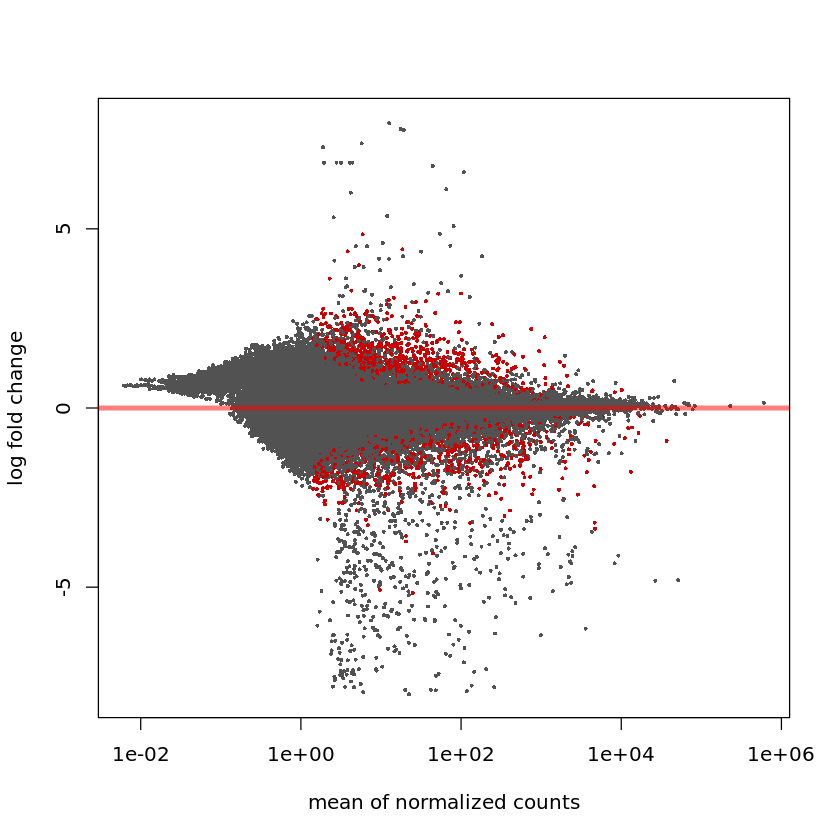

In [47]:
plotMA(res_clean, ylim=c(-8,8))

Now I'll shrink the LFCs for use later. We're using the `ashr` method throughout this analysis, which is able to handle both coefficients and contrasts, is useful for interaction terms, and does not over-shrink large LFCs. 

In [48]:
res_clean_shrunk <- lfcShrink(dds_clean, res=res_clean, type="ashr", parallel=TRUE)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


Plot the shrunk LFCs

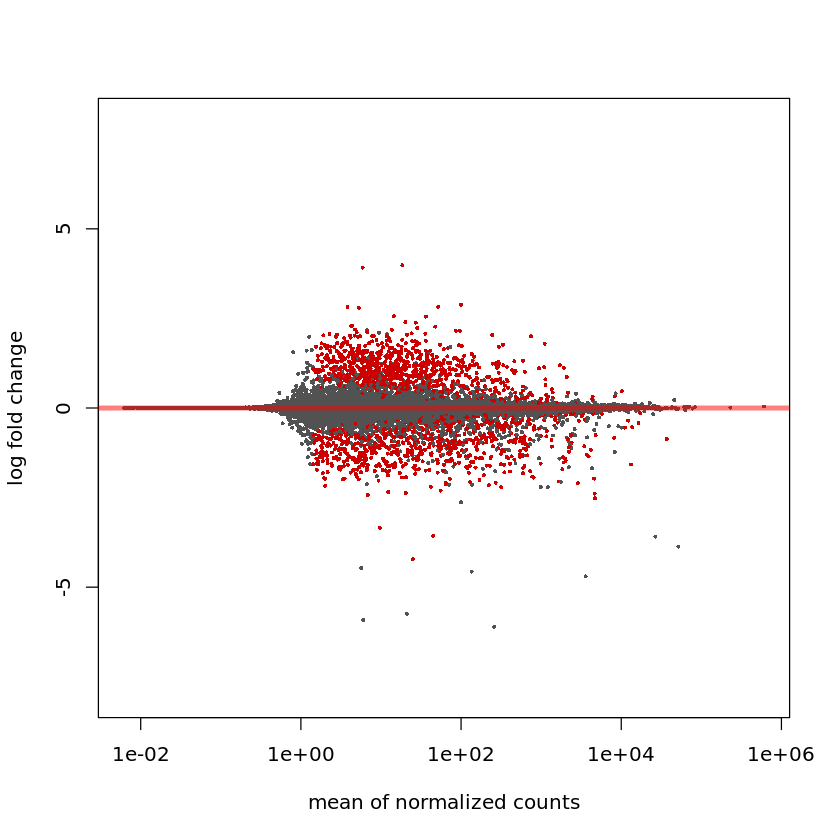

In [49]:
plotMA(res_clean_shrunk, ylim=c(-8,8))

Save the significant shrunk and unshrunk results:

In [50]:
res_clean_sig <- data.frame(subset(res_clean, padj < 0.05))
res_clean_shrunk_sig <- data.frame(subset(res_clean_shrunk, padj < 0.05))
res_clean_sig <- res_clean_sig[order(res_clean_sig$padj),]
res_clean_shrunk_sig <- res_clean_shrunk_sig[order(res_clean_shrunk_sig$padj),]
head(res_clean_shrunk_sig,20) #show the shrunk results

,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.798713,2.8819446,0.36048677,7.930190e-18,7.572062e-13
TRINITY_DN5780_c0_g1_i1,426.681391,-1.3512877,0.16665625,3.724894e-15,1.185559e-10
TRINITY_DN153818_c0_g1_i1,52.041840,2.8230704,0.39057997,3.421470e-15,1.185559e-10
TRINITY_DN10388_c0_g1_i1,40.116421,-1.7302057,0.23250682,2.224269e-13,5.309552e-09
TRINITY_DN94593_c0_g1_i1,35.996665,-1.7471493,0.23559158,3.146883e-13,6.009539e-09
TRINITY_DN26607_c0_g1_i1,96.198717,2.1585871,0.30386034,5.366589e-13,8.540390e-09
TRINITY_DN78527_c0_g1_i1,86.125843,2.1507868,0.31080999,1.194583e-12,1.425794e-08
TRINITY_DN112882_c0_g1_i1,13.399887,1.4695763,0.20862299,1.192162e-12,1.425794e-08
TRINITY_DN59586_c1_g1_i1,35.914280,2.0724231,0.31244525,3.261940e-12,3.460701e-08
TRINITY_DN11200_c0_g1_i2,192.171535,-1.8795634,0.25824456,4.552193e-12,4.346616e-08


Now I'm going to make another PCA, now that the potential conaminants have been removed.

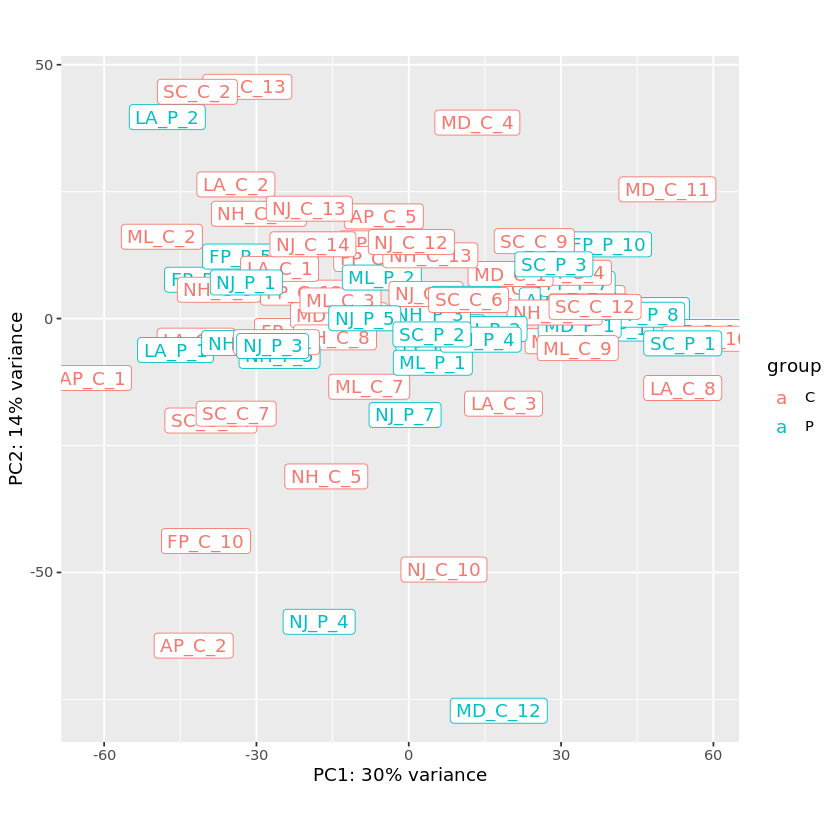

In [51]:
vsd <- vst(dds_clean, blind=FALSE)
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see now that they don't separate out. This is expected, as there is a lot of other variation present in the count data. This does not mean there aren't differences, however, as was shown above in the results summary. 

Just out of curiosity, let's plot one of the most significnatly differentially expressed transcripts and find it's annotation.

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
1812,TRINITY_DN5780_c0_g1_i1,tr|A0A2P2I073|A0A2P2I073_9CRUS,49.3,1.9e-103,58.7,tr|A0A2P2I073|A0A2P2I073_9CRUS Laminin subunit alpha-like (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas


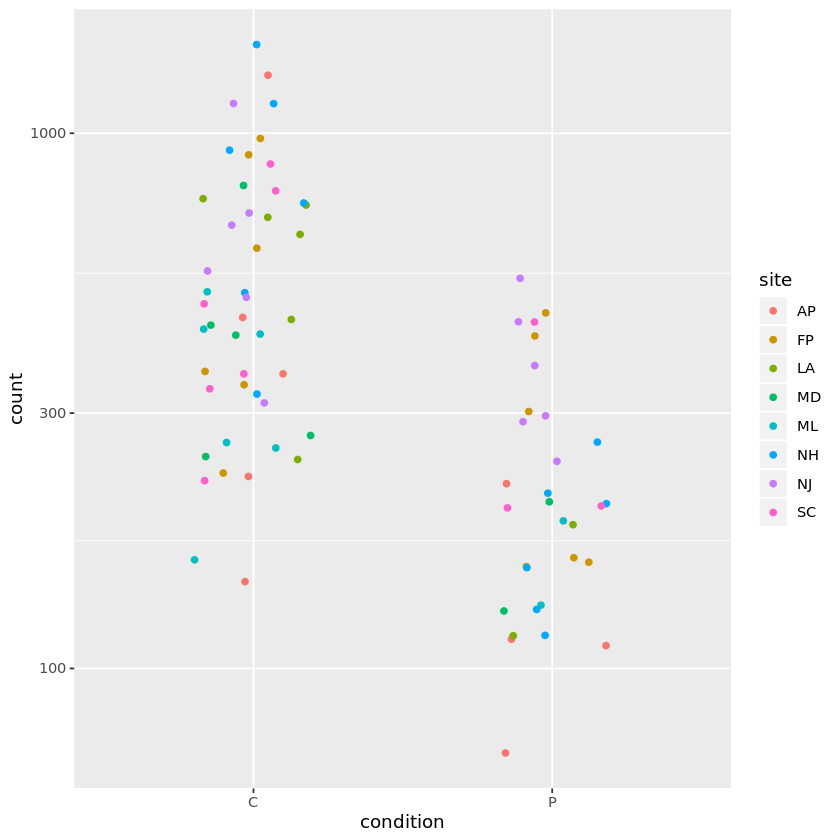

In [52]:
transcript <- "TRINITY_DN5780_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_clean, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site, group=range)) +
    #facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

Laminin is involved in innate immunity in arthropods. Interesting to see that it is downregulated. Perhaps the parasite is suppressing the crabs response. 

## Range-specific effects

Now that we have looked for bulk differences as a result of infection status, we can move on to look at differences among populations with different levels of historical exposure to the parasite. We included the FP samples in our first comparison because it was agnostic to range. However, because it is unresolved whether Loxo is native, invasive, or absent from FP, we are going to remove it from subsequent analyses.

We have to make another dds object. I am going to make it from scratch by removing all FP samples from the coldata and counts_clean.

In [53]:
counts_clean_noFP <- counts_clean[,!grepl("FP_*_*",colnames(counts_clean))]
coldata_noFP <- coldata[colnames(counts_clean_noFP),]

Let's just check to make sure they were removed.

In [54]:
dim(counts_clean_noFP)

[1] 143006     65

Just a quick sanity check to make sure the samples are in the same order in the counts and metadata matrices.

In [55]:
all(rownames(coldata_noFP) == colnames(counts_clean_noFP))

[1] TRUE

### Comparing infected vs control within ranges, controlling for site

With this pared down dataset, we'll do two different analyses. The first will be just looking at the difference between infected and control *within* each range. This allows us to control for site-specific effects within the ranges.

There is an added complication when correcting for individual effects that are nested within groups. I am implementing an approach outlined in the ["Group-specific condition effects, individuals nested within groups"](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#group-specific-condition-effects-individuals-nested-within-groups) section of the DESeq2 vignette. Essentially we just assign a unique identifier to each site by range.

In [56]:
print(coldata_noFP)

        site condition    range sex
AP_C_1    AP         C   Native   F
AP_C_2    AP         C   Native   F
AP_C_3    AP         C   Native   M
AP_C_4    AP         C   Native   M
AP_C_5    AP         C   Native   M
AP_P_1    AP         P   Native   F
AP_P_2    AP         P   Native   F
AP_P_3    AP         P   Native   F
AP_P_6    AP         P   Native   M
LA_C_1    LA         C   Native   M
LA_C_2    LA         C   Native   M
LA_C_3    LA         C   Native   F
LA_C_4    LA         C   Native   M
LA_C_6    LA         C   Native   F
LA_C_8    LA         C   Native   F
LA_P_1    LA         P   Native   M
LA_P_2    LA         P   Native   M
MD_C_10   MD         C Invasive   M
MD_C_11   MD         C Invasive   M
MD_C_12   MD         P Invasive   F
MD_C_1    MD         C Invasive   M
MD_C_4    MD         C Invasive   M
MD_C_7    MD         C Invasive   F
MD_P_1    MD         P Invasive   M
ML_C_10   ML         C Invasive   M
ML_C_2    ML         C Invasive   M
ML_C_3    ML         C Invas

We have to add a column assigning unique factors to each population *within* each range. We are going to add a column with the following values:

In [57]:
coldata_noFP$site.n <- factor(c(1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3))
print(coldata_noFP)

        site condition    range sex site.n
AP_C_1    AP         C   Native   F      1
AP_C_2    AP         C   Native   F      1
AP_C_3    AP         C   Native   M      1
AP_C_4    AP         C   Native   M      1
AP_C_5    AP         C   Native   M      1
AP_P_1    AP         P   Native   F      1
AP_P_2    AP         P   Native   F      1
AP_P_3    AP         P   Native   F      1
AP_P_6    AP         P   Native   M      1
LA_C_1    LA         C   Native   M      2
LA_C_2    LA         C   Native   M      2
LA_C_3    LA         C   Native   F      2
LA_C_4    LA         C   Native   M      2
LA_C_6    LA         C   Native   F      2
LA_C_8    LA         C   Native   F      2
LA_P_1    LA         P   Native   M      2
LA_P_2    LA         P   Native   M      2
MD_C_10   MD         C Invasive   M      1
MD_C_11   MD         C Invasive   M      1
MD_C_12   MD         P Invasive   F      1
MD_C_1    MD         C Invasive   M      1
MD_C_4    MD         C Invasive   M      1
MD_C_7    M

You can see now that each site has a unique number in relation to other sites in its range. They are repeated across ranges, but it doesn't matter because we are interested in looking at effects of infection within sites. 

Now we can make a model matrix that includes the terms we want to use in our forumlae.

In [58]:
mm <- model.matrix(~ range + range:site.n + range:condition, coldata_noFP)
head(mm)

,(Intercept),rangeInvasive,rangeNative,rangepara,rangeAbsent:site.n2,rangeInvasive:site.n2,rangeNative:site.n2,rangepara:site.n2,rangeAbsent:site.n3,rangeInvasive:site.n3,rangeNative:site.n3,rangepara:site.n3,rangeAbsent:conditionF,rangeInvasive:conditionF,rangeNative:conditionF,rangepara:conditionF,rangeAbsent:conditionP,rangeInvasive:conditionP,rangeNative:conditionP,rangepara:conditionP
AP_C_1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


It looks like our `coldata_FP` object still retained the `para` factor levels from we first read in the data to look for Loxo contamination. Let's get rid of those using `drop.levels()` from the `gdata` package. Then we'll make the model matrix again.

In [59]:
library(gdata)
coldata_noFP <- drop.levels(coldata_noFP)
mm <- model.matrix(~ range + range:site.n + range:condition, coldata_noFP)
head(mm)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:SummarizedExperiment’:

    trim

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:GenomicRanges’:

    trim

The following object is masked from ‘package:IRanges’:

    trim

The following objects are masked from ‘package:S4Vectors’:

    first, first<-

The following object is masked from ‘package:BiocGenerics’:

    combine

The following object is masked from ‘package:stats4’:

    nobs

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



,(Intercept),rangeInvasive,rangeNative,rangeAbsent:site.n2,rangeInvasive:site.n2,rangeNative:site.n2,rangeAbsent:site.n3,rangeInvasive:site.n3,rangeNative:site.n3,rangeAbsent:conditionP,rangeInvasive:conditionP,rangeNative:conditionP
AP_C_1,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,1,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,1,0,0,0,0,0,0,0,0,1


Okay now there is another issue. You can see from `mm` that the reference level has been set to `Absent`. We want it to be `Native`. Let's just relevel `coldata_noFP` and do it again. We'll also make sure the reference condition level is set to `C`, although it seems it already is.

In [60]:
coldata_noFP$range <- factor(coldata_noFP$range, levels = c("Native","Invasive","Absent"))
coldata_noFP$condition <- relevel(coldata_noFP$condition, ref = "C")

And make `mm` for the last time.

In [61]:
mm <- model.matrix(~ range + range:site.n + range:condition, coldata_noFP)
head(mm)

,(Intercept),rangeInvasive,rangeAbsent,rangeNative:site.n2,rangeInvasive:site.n2,rangeAbsent:site.n2,rangeNative:site.n3,rangeInvasive:site.n3,rangeAbsent:site.n3,rangeNative:conditionP,rangeInvasive:conditionP,rangeAbsent:conditionP
AP_C_1,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,0,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,0,0,0,0,0,0,0,1,0,0


Okay this all looks good now. I am going to detach `gdata` just in case it causes any conflicts.

In [62]:
detach("package:gdata", unload=TRUE)

Let's take a look at the full model matrix.

In [63]:
print(unname(mm))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12]
 [1,]    1    0    0    0    0    0    0    0    0     0     0     0
 [2,]    1    0    0    0    0    0    0    0    0     0     0     0
 [3,]    1    0    0    0    0    0    0    0    0     0     0     0
 [4,]    1    0    0    0    0    0    0    0    0     0     0     0
 [5,]    1    0    0    0    0    0    0    0    0     0     0     0
 [6,]    1    0    0    0    0    0    0    0    0     1     0     0
 [7,]    1    0    0    0    0    0    0    0    0     1     0     0
 [8,]    1    0    0    0    0    0    0    0    0     1     0     0
 [9,]    1    0    0    0    0    0    0    0    0     1     0     0
[10,]    1    0    0    1    0    0    0    0    0     0     0     0
[11,]    1    0    0    1    0    0    0    0    0     0     0     0
[12,]    1    0    0    1    0    0    0    0    0     0     0     0
[13,]    1    0    0    1    0    0    0    0    0     0     0     0
[14,]    1    0    0    1    0    

There are some columns with all zeros, which we need to remove.

In [64]:
all.zero <- apply(mm, 2, function(x) all(x==0))
idx <- which(all.zero)
mm <- mm[,-idx]
print(unname(mm))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    1    0    0    0    0    0    0    0    0     0
 [2,]    1    0    0    0    0    0    0    0    0     0
 [3,]    1    0    0    0    0    0    0    0    0     0
 [4,]    1    0    0    0    0    0    0    0    0     0
 [5,]    1    0    0    0    0    0    0    0    0     0
 [6,]    1    0    0    0    0    0    0    1    0     0
 [7,]    1    0    0    0    0    0    0    1    0     0
 [8,]    1    0    0    0    0    0    0    1    0     0
 [9,]    1    0    0    0    0    0    0    1    0     0
[10,]    1    0    0    1    0    0    0    0    0     0
[11,]    1    0    0    1    0    0    0    0    0     0
[12,]    1    0    0    1    0    0    0    0    0     0
[13,]    1    0    0    1    0    0    0    0    0     0
[14,]    1    0    0    1    0    0    0    0    0     0
[15,]    1    0    0    1    0    0    0    0    0     0
[16,]    1    0    0    1    0    0    0    1    0     0
[17,]    1    0    0    1    0 

In [65]:
colnames(mm)

[1] "(Intercept)"              "rangeInvasive"           
 [3] "rangeAbsent"              "rangeNative:site.n2"     
 [5] "rangeInvasive:site.n2"    "rangeAbsent:site.n2"     
 [7] "rangeInvasive:site.n3"    "rangeNative:conditionP"  
 [9] "rangeInvasive:conditionP" "rangeAbsent:conditionP"

Okay now we can create a dds object, specifying our model matrix as the design.

In [66]:
dds_range <- DESeqDataSetFromMatrix(countData = counts_clean_noFP, colData = coldata_noFP, design = mm)

converting counts to integer mode


In [67]:
dds_range <- DESeq(dds_range, parallel=TRUE)

using supplied model matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 16 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 16 workers


In [68]:
resultsNames(dds_range)

[1] "Intercept"                "rangeInvasive"           
 [3] "rangeAbsent"              "rangeNative.site.n2"     
 [5] "rangeInvasive.site.n2"    "rangeAbsent.site.n2"     
 [7] "rangeInvasive.site.n3"    "rangeNative.conditionP"  
 [9] "rangeInvasive.conditionP" "rangeAbsent.conditionP"

Here are all the coefficients we can choose from. Let's create three results objects for the comparisons within ranges.

In [69]:
native.PvC <- results(dds_range, alpha=0.05, parallel=TRUE, name="rangeNative.conditionP")
invasive.PvC <- results(dds_range, alpha=0.05, parallel=TRUE, name="rangeInvasive.conditionP")
absent.PvC <- results(dds_range, alpha=0.05, parallel=TRUE, name="rangeAbsent.conditionP")

In [70]:
summary(native.PvC)
summary(invasive.PvC)
summary(absent.PvC)


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 195, 0.14%
LFC < 0 (down)     : 292, 0.21%
outliers [1]       : 1887, 1.3%
low counts [2]     : 58749, 42%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1956, 1.4%
LFC < 0 (down)     : 1153, 0.82%
outliers [1]       : 1887, 1.3%
low counts [2]     : 66786, 48%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3964, 2.8%
LFC < 0 (down)     : 1188, 0.85%
outliers [1]       : 1887, 1.3%
low counts [2]     : 53429, 38%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In the native range, there are 195 upregulated and 292 downregulated, for a total of 487.

In the invasive range, there are 1956 upregulated and 1153 downregulated, for a total of 3109.

In the absent range, there are 3964 upregulated and 1188 downregulated, for a total of 5152.

Let's save these results to data.frames, using both the raw and shrunk LFCs.

In [71]:
native.PvC_df <- data.frame(subset(native.PvC, native.PvC$padj < 0.05))
native.PvC_df <- native.PvC_df[order(native.PvC_df$padj),]
native.PvC_shrunk <- lfcShrink(dds_range, res=native.PvC, type="ashr", parallel=TRUE)
native.PvC_shrunk_df <- data.frame(subset(native.PvC_shrunk, native.PvC_shrunk$padj < 0.05))
native.PvC_shrunk_df <- native.PvC_shrunk_df[order(native.PvC_shrunk_df$padj),]
invasive.PvC_df <- data.frame(subset(invasive.PvC, invasive.PvC$padj < 0.05))
invasive.PvC_df <- invasive.PvC_df[order(invasive.PvC_df$padj),]
invasive.PvC_shrunk <- lfcShrink(dds_range, res=invasive.PvC, type="ashr", parallel=TRUE)
invasive.PvC_shrunk_df <- data.frame(subset(invasive.PvC_shrunk, invasive.PvC_shrunk$padj < 0.05))
invasive.PvC_shrunk_df <- invasive.PvC_shrunk_df[order(invasive.PvC_shrunk_df$padj),]
absent.PvC_df <- data.frame(subset(absent.PvC, absent.PvC$padj < 0.05))
absent.PvC_df <- absent.PvC_df[order(absent.PvC_df$padj),]
absent.PvC_shrunk <- lfcShrink(dds_range, res=absent.PvC, type="ashr", parallel=TRUE)
absent.PvC_shrunk_df <- data.frame(subset(absent.PvC_shrunk, absent.PvC_shrunk$padj < 0.05))
absent.PvC_shrunk_df <- absent.PvC_shrunk_df[order(absent.PvC_shrunk_df$padj),]

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


Let's have a look at some of the top DE transcripts for each range, using the shrunk LFCs and looking at just those with LFCs greater than 2 or less than -2.

In [72]:
head(native.PvC_shrunk_df[abs(native.PvC_shrunk_df$log2FoldChange)>2,])
head(invasive.PvC_shrunk_df[abs(invasive.PvC_shrunk_df$log2FoldChange)>2,])
head(absent.PvC_shrunk_df[abs(absent.PvC_shrunk_df$log2FoldChange)>2,])

,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN109777_c0_g1_i1,59.498695,-25.14806,1.867288,5.707108e-42,4.536637e-37
TRINITY_DN9713_c0_g1_i1,97.092016,-29.15193,2.511076,5.143269e-32,2.044218e-27
TRINITY_DN136252_c0_g1_i1,4.590955,-20.87717,1.999009,5.743695e-26,1.521907e-21
TRINITY_DN133440_c0_g1_i1,17.207141,-18.14406,1.742949,1.050632e-25,2.087894e-21
TRINITY_DN82373_c0_g1_i1,78.424860,-28.65329,2.858894,1.768941e-24,2.812298e-20
TRINITY_DN150633_c0_g1_i1,3.070271,-18.17645,1.805238,3.560135e-24,4.716645e-20


,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN39168_c0_g1_i2,4.149094,-21.14043,1.428143,5.022849e-50,3.589027e-45
TRINITY_DN38142_c0_g1_i2,10.311648,-21.21882,1.554284,6.961191e-43,2.487025e-38
TRINITY_DN42035_c0_g1_i1,4.689274,-19.44683,1.455978,4.534173e-41,1.079949e-36
TRINITY_DN75942_c0_g1_i1,4.163979,-19.41786,1.463655,1.513414e-40,2.703487e-36
TRINITY_DN67550_c0_g1_i1,7.642013,-17.60755,1.379526,1.283043e-37,1.833571e-33
TRINITY_DN95607_c0_g1_i1,4.254069,-19.36088,1.530860,4.884814e-37,5.817326e-33


,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN6253_c0_g1_i1,18.557578,-22.38460,1.268600,3.498496e-70,2.967109e-65
TRINITY_DN152654_c0_g1_i1,2.331537,-29.06657,2.168611,7.995658e-42,3.390599e-37
TRINITY_DN130227_c0_g1_i1,4.017752,-15.92643,1.631734,9.215115e-23,2.605144e-18
TRINITY_DN24411_c0_g1_i1,24.657184,-17.06731,1.907309,1.821679e-19,3.089968e-15
TRINITY_DN20782_c0_g1_i1,436.702220,-24.38843,2.743473,1.480847e-19,3.089968e-15
TRINITY_DN8035_c0_g1_i1,8.559758,-14.41094,1.678505,5.560069e-18,7.859250e-14


Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species


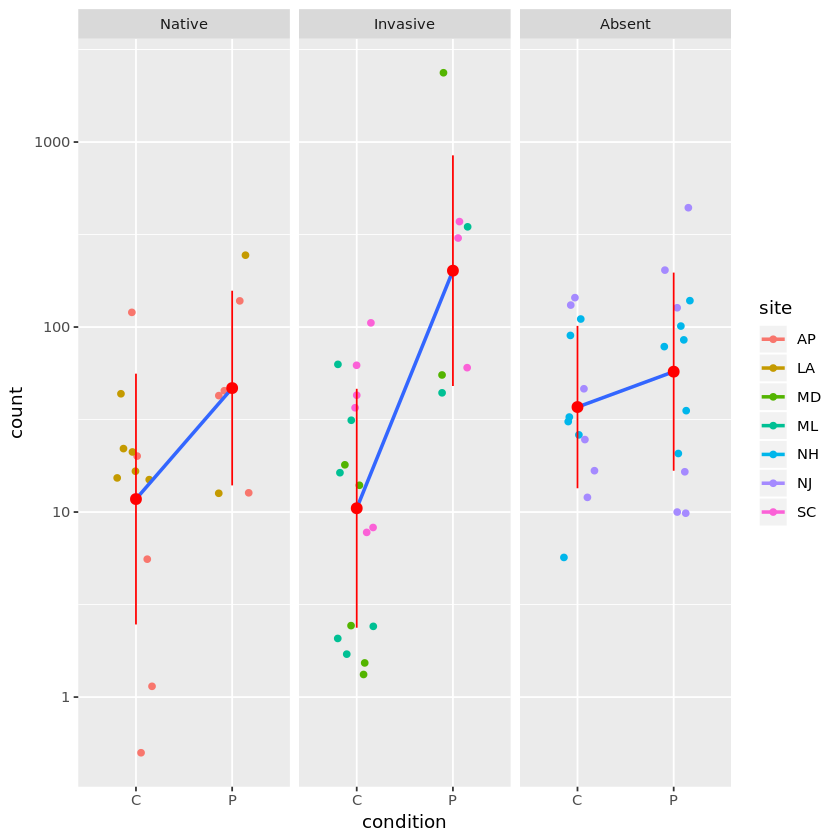

In [73]:
transcript <- "TRINITY_DN4450_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

Now we'll extract the transcript names of those that are up- or downregulated for making Venn diagrams.

In [74]:
native_DE_up <- rownames(native.PvC_df[native.PvC_df$log2FoldChange>0,])
native_DE_down <- rownames(native.PvC_df[native.PvC_df$log2FoldChange<0,])
invasive_DE_up <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange>0,])
invasive_DE_down <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange<0,])
absent_DE_up <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange>0,])
absent_DE_down <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange<0,])
length(native_DE_up)
length(native_DE_down)
length(invasive_DE_up)
length(invasive_DE_down)
length(absent_DE_up)
length(absent_DE_down)

[1] 195

[1] 292

[1] 1956

[1] 1153

[1] 3964

[1] 1188

Good, these correspond to the numbers seen earlier in the summaries.

Now to make some Venn diagrams.

In [75]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
myCol <- brewer.pal(3, "Set1")
venn.diagram(
        x = list(native_DE_up, invasive_DE_up, absent_DE_up),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_up.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(native_DE_down, invasive_DE_down, absent_DE_down),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_down.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(c(native_DE_down,native_DE_up), c(invasive_DE_down,invasive_DE_up), c(absent_DE_down,absent_DE_up)),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_both.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

NULL

[1] 1

[1] 1

[1] 1

And an upset plot:

Loading required package: UpSetR


png 
  2

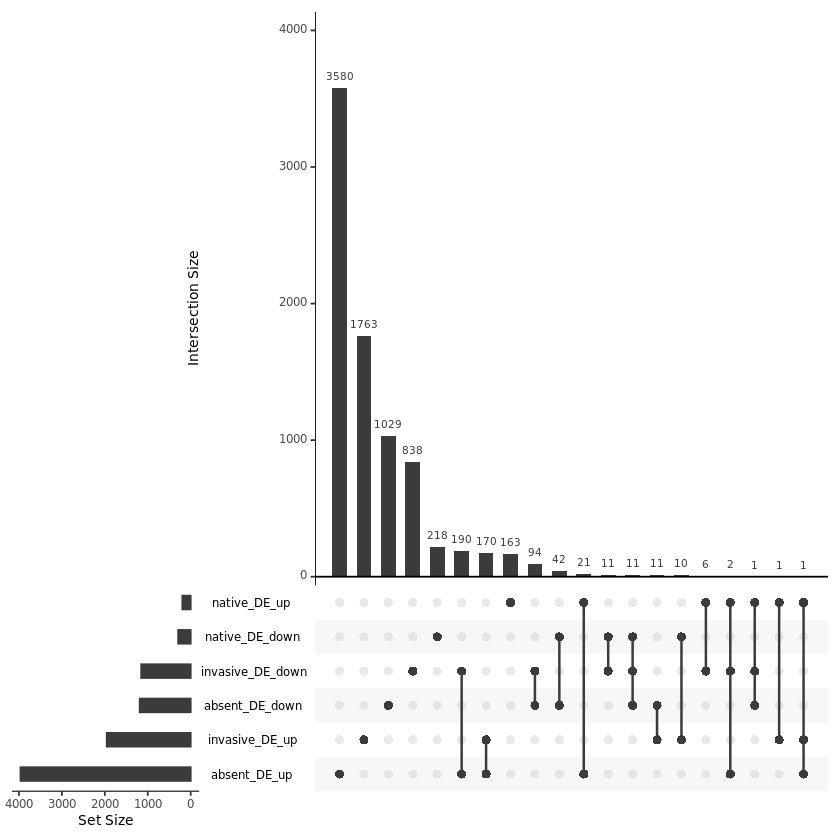

In [76]:
require(UpSetR)
listInput <- list(
    native_DE_up = native_DE_up,
    native_DE_down = native_DE_down,
    invasive_DE_up = invasive_DE_up,
    invasive_DE_down =  invasive_DE_down,
    absent_DE_up = absent_DE_up,
    absent_DE_down = absent_DE_down
)
sets <- fromList(listInput)
upset_plot <- upset(sets, sets = names(listInput), order.by = "freq", nsets=6, mb.ratio=c(0.7,.3))
png("../vis/upset_range_PvC.png", height=10, width=10, units = "in", res=200)
upset_plot
dev.off()
upset_plot
detach("package:UpSetR", unload=TRUE)

You can have a look at these in the `vis/` directory. Now on to our last comparison.

### Testing for interactions between range and condition

Here we will investigate differences in the transcriptional response to parasitism *among* ranges. That is, we will search for transcripts that display a significant interaction between `condition` and `range` in the model. Note that here we cannot control for site-specific effects as we did in the last comparison. This is not a flaw in the experimental design; it is simply that there is no way to have one site occur across ranges in order to control for it, i.e. NH cannot simultaneously be in three ranges. This deviates from the mostly biomedical examples from the vignette and other DESeq2 resources, in which they can control for individual/genotype specific effect across different combinations of treatments. 

We'll make a another dds object, this time called `dds_interaction`. We'll use the same counts and sample metadata as in the previous comparison.

In [77]:
dds_interaction <- DESeqDataSetFromMatrix(countData = counts_clean_noFP, colData = coldata_noFP, design = ~range + condition + range:condition)

converting counts to integer mode


We are going to do a likelihood ratio test for this comparison, comparing the full model specified in the design above, and a reduced model that includes just `range` and `condition`, but no interaction. 

In [78]:
dds_interaction <- DESeq(dds_interaction, parallel=TRUE, test="LRT", reduced=~range + condition)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 16 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 16 workers
-- replacing outliers and refitting for 4723 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [79]:
resultsNames(dds_interaction)

[1] "Intercept"                "range_Invasive_vs_Native"
[3] "range_Absent_vs_Native"   "condition_P_vs_C"        
[5] "rangeInvasive.conditionP" "rangeAbsent.conditionP"

Let's save the results. We'll skip the shrunk LFCs for now, because it doesn't change the number of significant transcripts. We'll use it later on when building contrasts between interactions. 

In [80]:
res_interaction <- results(dds_interaction, alpha=0.05, parallel=TRUE) #results of full vs. reduced LRT

In [81]:
summary(res_interaction)


out of 139828 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4066, 2.9%
LFC < 0 (down)     : 2829, 2%
outliers [1]       : 236, 0.17%
low counts [2]     : 65205, 47%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



You can see from the summary that there are 6895 transcripts that show a significant interaction.

Let's save these to a data.frame.

In [82]:
res_interaction_df <- na.omit(data.frame(subset(res_interaction, res_interaction$padj < 0.05)))
res_interaction_df <- res_interaction_df[order(res_interaction_df$padj),] #sort by padj
dim(res_interaction_df)
head(res_interaction_df)

[1] 6895    6

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN2762_c0_g1_i2,927.58552,-0.1871544,0.1315897,58.62412,1.861808e-13,1.390510e-08
TRINITY_DN6746_c0_g1_i1,216.99005,0.4032642,0.3211368,54.77867,1.273395e-12,4.755240e-08
TRINITY_DN7634_c0_g1_i1,67.16612,3.6265314,0.9274471,53.64193,2.248036e-12,5.596561e-08
TRINITY_DN22480_c0_g1_i1,48.74319,1.2685221,0.3413515,52.29008,4.419307e-12,8.251510e-08
TRINITY_DN21081_c0_g1_i1,19.72579,1.6313440,1.1491325,49.97849,1.403812e-11,1.842713e-07
TRINITY_DN21593_c0_g1_i1,71.04811,3.5141884,1.3627613,49.87229,1.480368e-11,1.842713e-07


6895 transcripts, almost 5% of the entire set, display some sort of interaction between range and condition. Seems really high, but remember that we can't control for site-specific effects. Also, population genomic differences between the sites probably also contributes to this, as many contigs in the transcriptome may be supported by crabs only from a certain site or set of sites. 

Let's look at the expression patterns of select transcripts with annotations. Here we are selecting only those that match to a decapod reference sequence. 

In [6]:
decapod_annot <- annot[grepl("decapoda",annot[,15]),]

In [7]:
length(rownames(res_interaction_df[rownames(res_interaction_df) %in% decapod_annot[,1],]))
head(res_interaction_df[rownames(res_interaction_df) %in% decapod_annot[,1],],30)
top30 <- rownames(head(res_interaction_df[rownames(res_interaction_df) %in% decapod_annot[,1],],30))

[1] 784

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN2762_c0_g1_i2,927.585518,-0.18715439,0.1315897,58.62412,1.861808e-13,1.390510e-08
TRINITY_DN283_c0_g1_i2,7716.285813,-0.06097526,0.1520849,40.65359,1.486572e-09,5.843478e-06
TRINITY_DN21043_c0_g1_i1,92.787842,4.89533489,1.5134258,36.35869,1.272947e-08,2.796216e-05
TRINITY_DN83447_c0_g1_i1,29.117166,-0.25850300,0.6537150,34.24455,3.663452e-08,5.472171e-05
TRINITY_DN10862_c0_g1_i1,189.456412,2.21906009,0.9194398,33.74065,4.713154e-08,5.870050e-05
TRINITY_DN3688_c0_g1_i1,1111.996682,0.05665785,0.1728557,32.30378,9.667716e-08,9.807542e-05
TRINITY_DN8188_c0_g1_i1,298.439126,0.12819561,0.1742065,31.19835,1.680217e-07,1.280496e-04
TRINITY_DN26483_c0_g1_i1,104.847152,-0.05052441,0.2975131,31.09322,1.770896e-07,1.322611e-04
TRINITY_DN93803_c0_g1_i1,74.584405,1.87934497,0.7907065,30.61916,2.244578e-07,1.458477e-04
TRINITY_DN60490_c0_g1_i1,25.198796,4.37363437,1.3062188,30.61586,2.248285e-07,1.458477e-04


There are 784 that have annotations to decapod reference sequences. 

Those listed above are the top thirty transcripts by adjusted p-value that have decapod annotations. Copy a transcript ID of interest and paste into `transcript` below to get annotation and plot counts.

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
15051,TRINITY_DN15069_c0_g1_i1,XP_027230619.1,62.8,1.1e-140,84.9,XP_027230619.1 acid ceramidase-like isoform X1 [Penaeus vannamei],penaeus vannamei


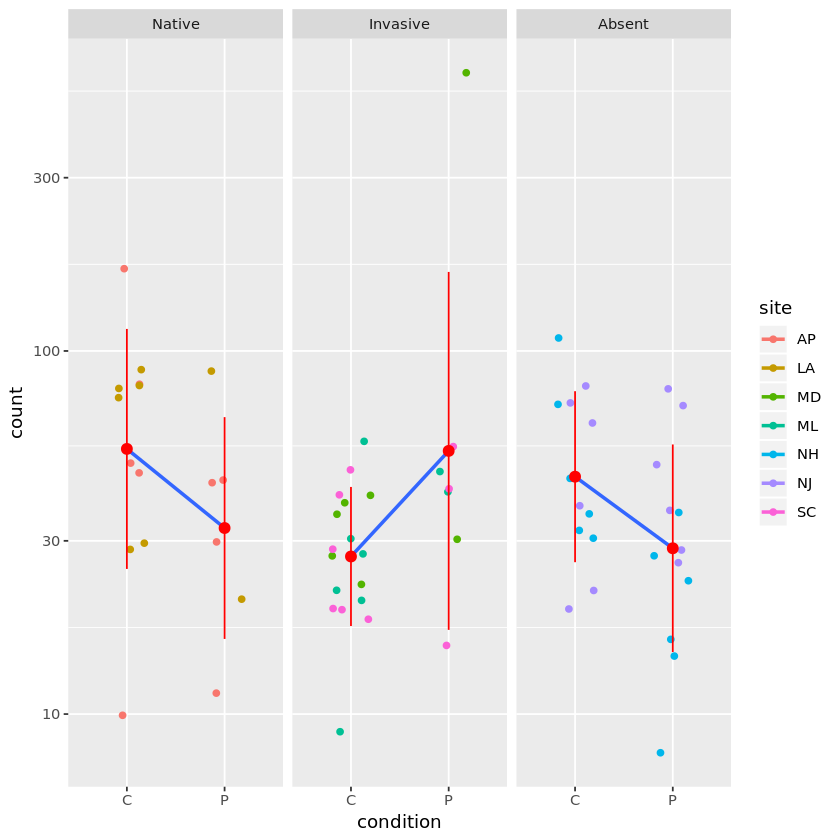

In [125]:
transcript <- "TRINITY_DN15069_c0_g1_i1"
decapod_annot[decapod_annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

Below I am going to export a selection of counts plots of most significant transcripts showing an interaction, using only those with informative decapod annotations (no hypothetical or unknown proteins). I am going to write the `plotCounts()` function into another function with all the arguments pre-specified to save space. 

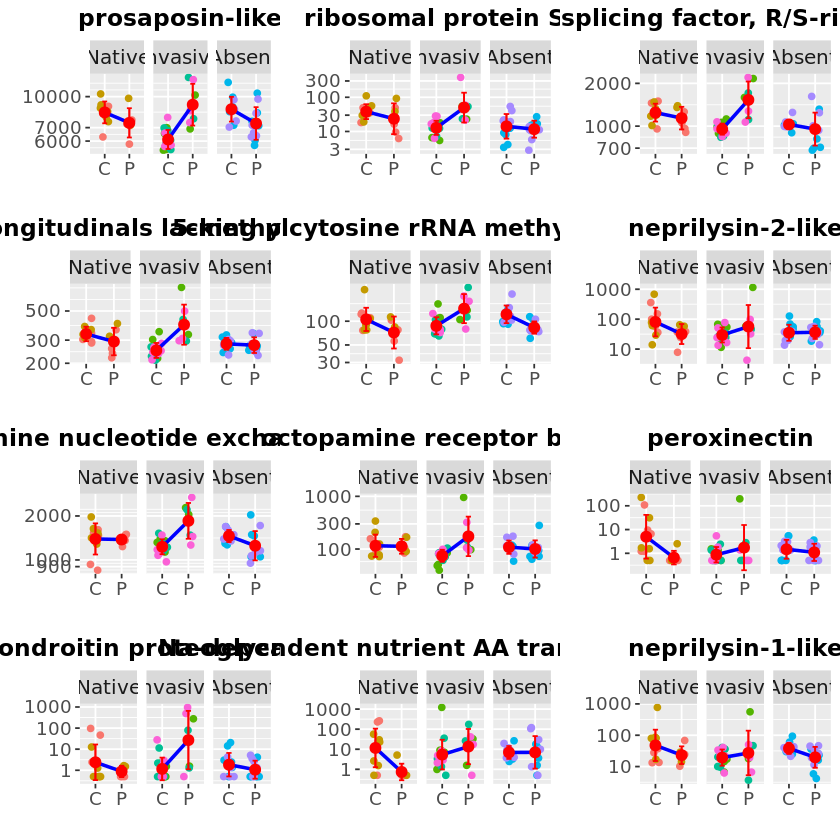

In [136]:
easy_plotCounts <- function(ID){
    transcript <- ID
    count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
    ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
        facet_grid(.~range) +
        theme(strip.text.x = element_text(size = 12), 
              axis.text.x = element_text(size=11), 
              axis.text.y = element_text(size=11)) +
        xlab("") +
        ylab("") +
        geom_point(position=position_jitter(w=0.2,h=0), show.legend = FALSE) + 
        geom_smooth(method = "lm", se=F, aes(group=1), show.legend = FALSE, color = "blue") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="red", width=0.2) +
        scale_y_log10()#limits = c(1,1e6)) 
}

add_title <- function(transcript, title){
     easy_plotCounts(transcript) + 
        ggtitle(title) + 
        theme(plot.title = element_text(hjust=0.5,size=14,face="bold"),legend.position="none")
}

p1 <- add_title("TRINITY_DN283_c0_g1_i2", "prosaposin-like")
p2 <- add_title("TRINITY_DN83447_c0_g1_i1", "ribosomal protein S24")
p3 <- add_title("TRINITY_DN3688_c0_g1_i1", "splicing factor, R/S-rich 18")
p4 <- add_title("TRINITY_DN8188_c0_g1_i1", "longitudinals lacking protein")
p5 <- add_title("TRINITY_DN26483_c0_g1_i1", "5-methylcytosine rRNA methyltransferase")
p6 <- add_title("TRINITY_DN93803_c0_g1_i1", "neprilysin-2-like")
p7 <- add_title("TRINITY_DN987_c0_g1_i1", "rho guanine nucleotide exchange factor 10")
p8 <- add_title("TRINITY_DN24588_c0_g1_i1", "octopamine receptor beta-2R")
p9 <- add_title("TRINITY_DN82197_c0_g1_i1", "peroxinectin")
p10 <- add_title("TRINITY_DN109614_c0_g1_i1", "chondroitin proteoglycan 2-like")
p11 <- add_title("TRINITY_DN31392_c0_g1_i1", "Na-dependent nutrient AA transporter 1-like")
p12 <- add_title("TRINITY_DN5164_c1_g1_i1", "neprilysin-1-like")
p13 <- add_title("TRINITY_DN15069_c0_g1_i1", "acid ceramidase-like ")

library("cowplot")

main <- plot_grid(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12, nrow=4, ncol=3)
#legend <- get_legend(plot1  + guides(color = guide_legend(nrow = 1)) + theme(legend.position = "bottom"))
#done <- plot_grid(main, legend, nrow=4,ncol=3)

main

save_plot("../vis/DESeq2_top_interaction_genes.png", plot=main, nrow=4, ncol=3)


The plot doesn't render well in jupyter. Take a look at the output in `vis/`.

Now we can make contrasts between the interaction terms to see in which ways the responses are different between pairs of ranges. We'll also save the shrunk results using the `ashr` method, which can handle both coefficients/names and contrasts.

In [85]:
res_interaction_AvN <- results(dds_interaction, alpha=0.05, parallel=TRUE, name="rangeAbsent.conditionP", test="Wald")
res_interaction_IvN <- results(dds_interaction, alpha=0.05, parallel=TRUE, name="rangeInvasive.conditionP", test="Wald")
res_interaction_AvI <- results(dds_interaction, alpha=0.05, parallel=TRUE, contrast=list("rangeAbsent.conditionP","rangeInvasive.conditionP"), test="Wald")
res_interaction_AvN_shrunk <- lfcShrink(dds_interaction, res=res_interaction_AvN, type="ashr", parallel=TRUE)
res_interaction_IvN_shrunk <- lfcShrink(dds_interaction, res=res_interaction_IvN, type="ashr", parallel=TRUE)
res_interaction_AvI_shrunk <- lfcShrink(dds_interaction, res=res_interaction_AvI, type="ashr", parallel=TRUE)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


In [86]:
summary(res_interaction_AvN)
summary(res_interaction_IvN)
summary(res_interaction_AvI)


out of 139828 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 164, 0.12%
LFC < 0 (down)     : 127, 0.091%
outliers [1]       : 236, 0.17%
low counts [2]     : 62505, 45%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 139828 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1243, 0.89%
LFC < 0 (down)     : 1727, 1.2%
outliers [1]       : 236, 0.17%
low counts [2]     : 59804, 43%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 139828 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3907, 2.8%
LFC < 0 (down)     : 1711, 1.2%
outliers [1]       : 236, 0.17%
low counts [2]     : 59804, 43%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now we'll place the results in data.frames.

In [87]:
#unshrunk
res_interaction_AvN_df <- na.omit(data.frame(subset(res_interaction_AvN, res_interaction_AvN$padj < 0.05)))
res_interaction_IvN_df <- na.omit(data.frame(subset(res_interaction_IvN, res_interaction_IvN$padj < 0.05)))
res_interaction_AvI_df <- na.omit(data.frame(subset(res_interaction_AvI, res_interaction_AvI$padj < 0.05)))
res_interaction_AvN_df <- res_interaction_AvN_df[order(res_interaction_AvN_df$padj),]
res_interaction_IvN_df <- res_interaction_IvN_df[order(res_interaction_IvN_df$padj),]
res_interaction_AvI_df <- res_interaction_AvI_df[order(res_interaction_AvI_df$padj),]

#shrunk
res_interaction_AvN_shrunk_df <- na.omit(data.frame(subset(res_interaction_AvN_shrunk, res_interaction_AvN_shrunk$padj < 0.05)))
res_interaction_IvN_shrunk_df <- na.omit(data.frame(subset(res_interaction_IvN_shrunk, res_interaction_IvN_shrunk$padj < 0.05)))
res_interaction_AvI_shrunk_df <- na.omit(data.frame(subset(res_interaction_AvI_shrunk, res_interaction_AvI_shrunk$padj < 0.05)))
res_interaction_AvN_shrunk_df <- res_interaction_AvN_shrunk_df[order(res_interaction_AvN_shrunk_df$padj),]
res_interaction_IvN_shrunk_df <- res_interaction_IvN_shrunk_df[order(res_interaction_IvN_shrunk_df$padj),]
res_interaction_AvI_shrunk_df <- res_interaction_AvI_shrunk_df[order(res_interaction_AvI_shrunk_df$padj),]

#show shrunk
head(res_interaction_AvN_shrunk_df,10)
head(res_interaction_IvN_shrunk_df,10)
head(res_interaction_AvI_shrunk_df,10)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN79615_c0_g1_i1,21.198719,22.74244,1.866662,1.086868e-34,8.410834e-30
TRINITY_DN109777_c0_g1_i1,4.459163,20.25996,2.418992,1.998264e-17,7.731884e-13
TRINITY_DN136252_c0_g1_i1,4.590955,19.10238,2.468307,4.055860e-15,1.046223e-10
TRINITY_DN181_c0_g1_i3,8.313725,19.39910,2.836934,3.111024e-12,6.018742e-08
TRINITY_DN144120_c0_g1_i1,7.351526,19.05771,2.840500,7.802749e-12,1.207647e-07
TRINITY_DN112559_c0_g1_i1,6.646491,21.63877,3.413078,6.707669e-11,8.651328e-07
TRINITY_DN155000_c0_g1_i1,3.752222,17.47496,2.747740,8.961511e-11,9.907078e-07
TRINITY_DN20782_c0_g1_i1,436.702220,-25.38239,4.384208,9.466170e-10,9.156862e-06
TRINITY_DN9713_c0_g1_i1,9.730595,20.12642,3.498521,1.977392e-09,1.530225e-05
TRINITY_DN278_c0_g2_i2,5.926292,18.30329,3.156890,1.841688e-09,1.530225e-05


,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN79615_c0_g1_i1,21.198719,20.836418,1.9497771,4.201120e-27,3.364551e-22
TRINITY_DN38142_c0_g1_i2,10.311648,-22.511215,2.1586764,5.602371e-26,2.243386e-21
TRINITY_DN136252_c0_g1_i1,4.590955,24.328006,2.4656696,1.437029e-23,3.836244e-19
TRINITY_DN155000_c0_g1_i1,3.752222,22.923249,2.7510422,2.225230e-17,4.455300e-13
TRINITY_DN142173_c0_g1_i1,2.902181,21.418236,2.7207887,1.103293e-15,1.767189e-11
TRINITY_DN7634_c0_g1_i1,67.166124,6.938196,0.9897502,3.768735e-15,5.030445e-11
TRINITY_DN21593_c0_g1_i1,71.048105,9.792027,1.6009922,1.377042e-13,1.575474e-09
TRINITY_DN109777_c0_g1_i1,4.459163,17.202957,2.6627477,1.742651e-11,1.550708e-07
TRINITY_DN21043_c0_g1_i1,92.787842,9.552817,1.7995159,1.733092e-11,1.550708e-07
TRINITY_DN32458_c0_g1_i1,36.449878,-4.116686,0.7489087,4.950728e-11,3.964890e-07


,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN38142_c0_g1_i2,10.311648,19.7433820,2.0470886,3.703477e-22,2.966003e-17
TRINITY_DN20782_c0_g1_i1,436.702220,-38.2076069,4.1082473,3.875219e-21,1.551773e-16
TRINITY_DN49536_c0_g1_i1,23.628608,-32.4632432,3.7718875,2.982022e-18,5.970529e-14
TRINITY_DN114091_c0_g1_i1,11.257609,-34.7353786,4.0304827,2.349458e-18,5.970529e-14
TRINITY_DN6746_c0_g1_i1,216.990054,2.1120027,0.3121058,6.834550e-14,1.094717e-09
TRINITY_DN22480_c0_g1_i1,48.743195,2.2221072,0.3343780,2.285755e-13,2.646927e-09
TRINITY_DN2762_c0_g1_i2,927.585518,-0.8552473,0.1212975,2.313545e-13,2.646927e-09
TRINITY_DN150028_c0_g1_i1,2.665521,33.9164377,4.9961269,3.994916e-12,3.999261e-08
TRINITY_DN155242_c0_g1_i1,7.720369,-45.2711181,6.8192325,4.596594e-12,4.090305e-08
TRINITY_DN970_c0_g1_i1,238.865762,2.2255174,0.3773471,2.154979e-11,1.451480e-07


It doesn't seem to be shrinking the LFCs... I think it is because the contrasts weren't specified in the `lfcShrink()` calls above. Don't worry about this for now. The pvalues should be similar if not identical. 

This one shows an interesting pattern related to the trematode parasitism. "TRINITY_DN22600_c0_g1_i1"

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
12025,TRINITY_DN22600_c0_g1_i1,ADO32981.1,98.7,1.3e-78,99.6,ADO32981.1 polyubiquitin [Eriocheir sinensis],eriocheir sinensis


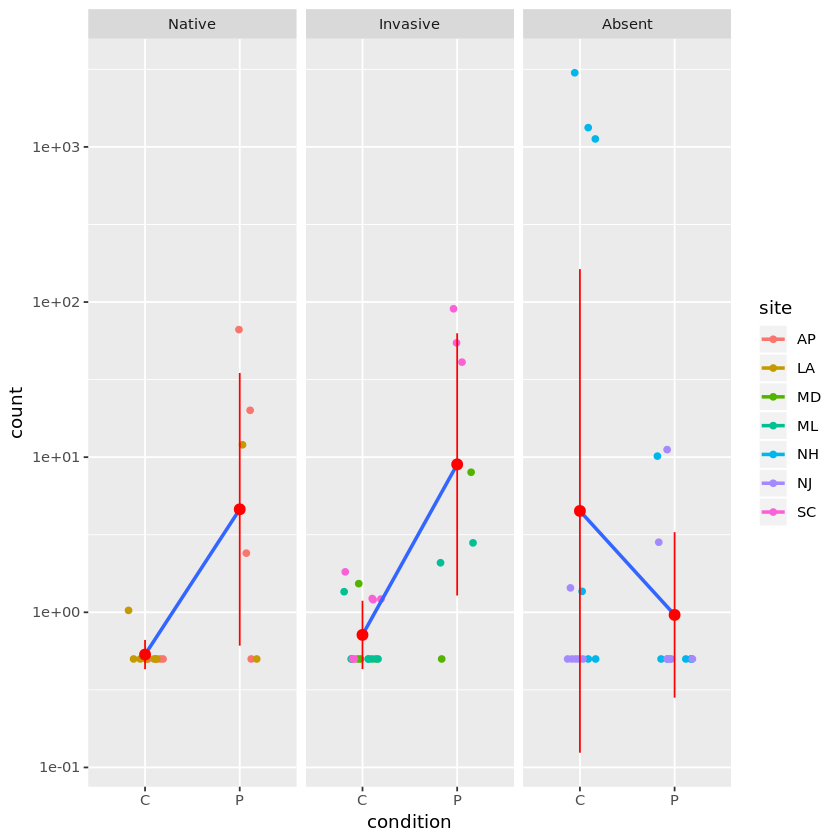

In [88]:
transcript <- "TRINITY_DN22600_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

This came up as the second most significant when contrasting the range:condition interaction between absent and native. You can see that it's mostly driven by the three NH samples. If you were to remove them, you would see that the all ranges would move in the same direction. What I think is most likely is that reads originating from a parasite other than Loxo in the NH crabs (trematode, maybe entoniscid, since it's crustacean?) are mapping to the crab ubiquitin. Thus you see really high read counts. This transcript wasn't removed in the prefiltering stage because overall it didn't exhibit a really negative LFC. Something to be aware of, not sure it's something we can correct for without going through all of the transcripts manually. I guess what one could do is remove all transcripts that have their highest normalized count in one of these three crabs (or top three are in the three, to be more stringent), like we did for the Loxo samples, but I think that's getting a little too far down the rabbit hole. Start of some test code below for doing so, if interested later.

In [89]:
#test <- counts(dds_interaction, normalized=TRUE)
##colnames(test[,c(33,35,37)])
#test_names <- test[max.col(test) %in% c(33,35,37),]
##head(test_names)
#print(data.frame(head(test_names)))

Looking at some more count plots. 

Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species


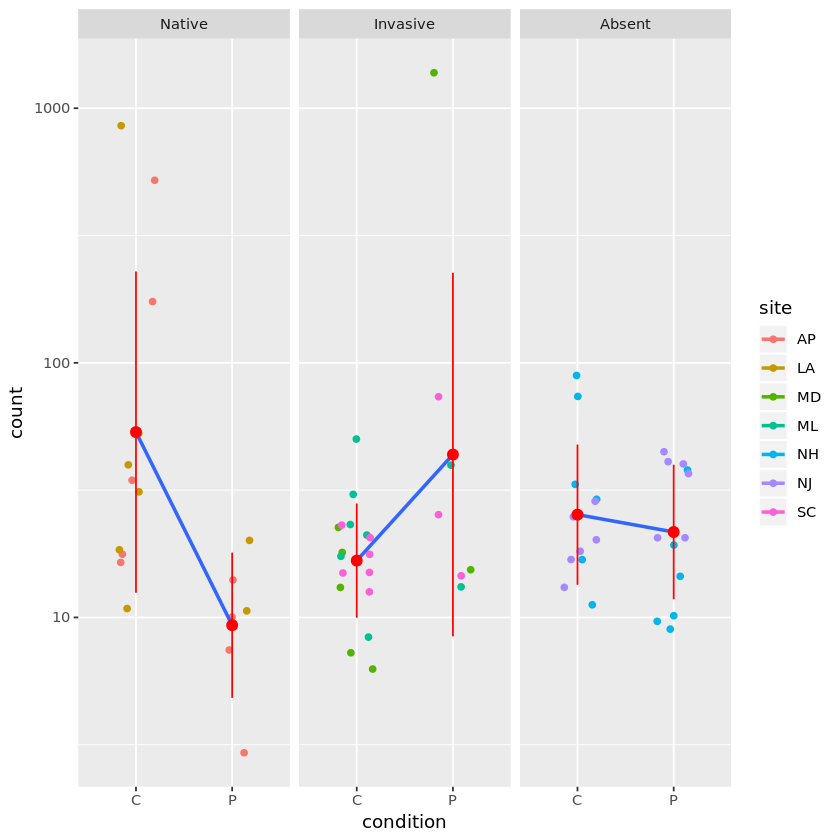

In [143]:
transcript <- "TRINITY_DN7634_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

*NOTES*

It's looking like for the most part when we see a significant interaction, the invasive populations have the opposite pattern of both the native AND the absent. What could this mean biologically? Naive hosts from the absent range display mostly similar responses to those from the native range. Is this evolutionarily meaningful? Hosts from the absent range haven't evolved to mount a defense in certain pathways, but neither do the native hosts, perhaps because they have a different resistance mechanism? Behavior? It might also be ecologically relevant in that the populations in the invasive range have really high parasite burdens, whereas in the native range it is really low, and none in the absent range (obviously). So it might just be that native hosts have means of avoiding parasitism that don't rely on mounting the sort of defense that those in the invasive range do. Should dig into this further.

Could be an effect of population size as well. Perhaps the gulf crab populations are just much bigger, so they have some demographic means of avoiding parasitism. The rate of parasitism is so low (chances of getting infected), that there isn't a incentive to evolve molecular defenses. Could be other ecological factors. Maybe there are predators of the parasite larvae in the native range that lessen load on the native hosts. Perhaps this predator is missing in the invasive range. I can't imagine there are many loxo-larvae-specialists, so I imagine rates of predation on them would be similar across environments... There are so many potential explanations. 

Maybe in the native range some transcripts that in the other ranges are upregulated during infection are just expressed at higher basal levels without infection, perhaps preemptively staving off the parasite. 

Make lists of the transcripts IDs to look at directionality.

In [90]:
absent_up_native_down <- rownames(res_interaction_AvN_df[res_interaction_AvN_df$log2FoldChange > 0,])
absent_down_native_up <- rownames(res_interaction_AvN_df[res_interaction_AvN_df$log2FoldChange < 0,])
invasive_up_native_down <- rownames(res_interaction_IvN_df[res_interaction_IvN_df$log2FoldChange > 0,])
invasive_down_native_up <- rownames(res_interaction_IvN_df[res_interaction_IvN_df$log2FoldChange < 0,])
absent_up_invasive_down <- rownames(res_interaction_AvI_df[res_interaction_AvI_df$log2FoldChange > 0,])
absent_down_invasive_up <- rownames(res_interaction_AvI_df[res_interaction_AvI_df$log2FoldChange < 0,])
length(absent_up_native_down)
length(absent_down_native_up)
length(invasive_up_native_down)
length(invasive_down_native_up)
length(absent_up_invasive_down)
length(absent_down_invasive_up)

[1] 164

[1] 127

[1] 1243

[1] 1727

[1] 3907

[1] 1711

Loading required package: UpSetR


png 
  2

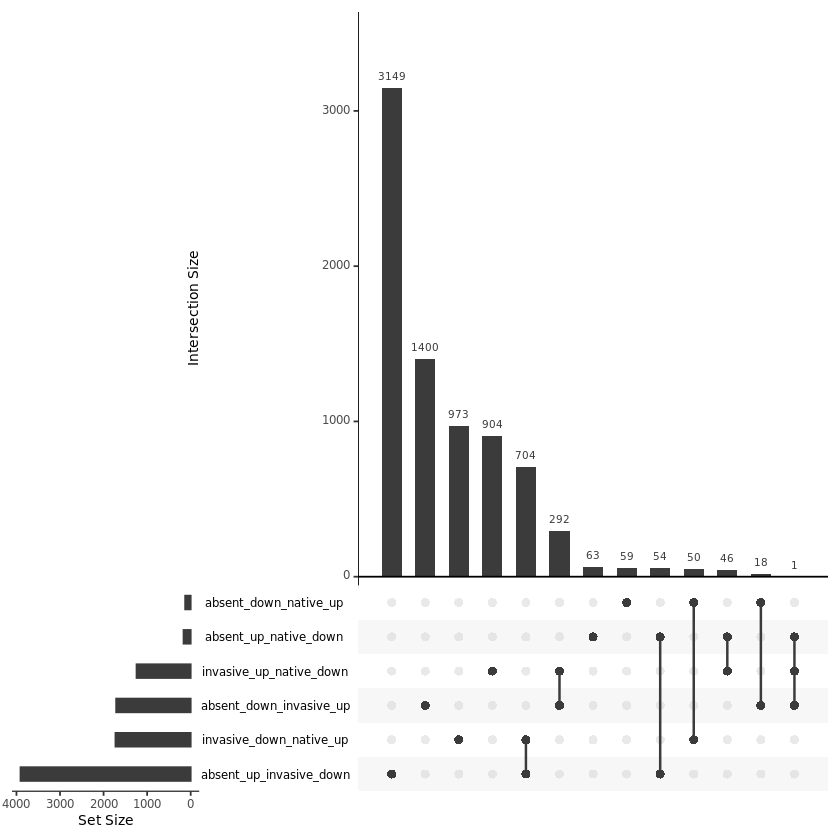

In [91]:
require(UpSetR)
listInput <- list(
    absent_up_native_down = absent_up_native_down,
    absent_down_native_up = absent_down_native_up,
    invasive_up_native_down = invasive_up_native_down,
    invasive_down_native_up = invasive_down_native_up,
    absent_up_invasive_down = absent_up_invasive_down,
    absent_down_invasive_up = absent_down_invasive_up
)
sets <- fromList(listInput)
upset_plot <- upset(sets, sets = names(listInput), order.by = "freq", nsets=6, mb.ratio=c(0.7,.3))
png("../vis/upset_interaction_contrast.png", height=10, width=10, units = "in", res=200)
upset_plot
dev.off()
upset_plot

Below I am just going to make a Venn diagram showing the intersections between AvN, IvN, and AvI. This doesn't specify direction (uses union of range1_down_range2_up, etc.)

In [144]:
length(absent_down_native_up)
length(absent_up_native_down)
length(c(absent_down_native_up,absent_up_native_down))

[1] 127

[1] 164

[1] 291

In [147]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
venn.diagram(
        x = list(c(absent_up_native_down,absent_down_native_up), 
                 c(invasive_up_native_down,invasive_down_native_up), 
                 c(absent_up_invasive_down,absent_down_invasive_up)),
        category.names = c("A vs. N" , "I vs. N" , "A vs. I"),
        filename = '../vis/venn_interaction_contrast.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

NULL

[1] 1

## Export data for `WGCNA` and `GO_MWU`

Before we finish, I need to export a matrix of counts to use downstream in WGCNA. The creators [suggest](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) removing transcripts with consistently low counts to avoid spurious correlations, and the also recommend performing a variance stabilizing transformation. I will do both below and then export as a tsv.

I am going to export both on containing FP individuals and one without. 

I am removing all transcripts that have normalized counts of less than 20 in over 90% of the samples (69/77 for clean, 58/65 for clean_noFP).

In [13]:
#filterGenes <- rowMeans(counts(dds_clean, normalized=TRUE)) < ? #alternative for filtering by rowMeans
filterGenes <- rowSums(counts(dds_clean, normalized=TRUE) < 20 ) > 69 #transcripts with less than 20 in over 69 samp
for_export <- dds_clean[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_FP_in.tsv", sep="\t")
#filterGenes <- rowMeans(counts(dds_range, normalized=TRUE)) < ? #alternative for filtering by rowMeans
filterGenes <- rowSums(counts(dds_range, normalized=TRUE) < 20 ) > 58 #transcripts with less than 20 in over 58 samp
for_export <- dds_range[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_noFP_in.tsv", sep="\t")

Now for the `GO_MWU` data. We'll export both the LFCs and the  pvalues from the base PvC comparison and just the pvalues from the range:condition interaction LRT, because testing between three groups it's unclear to me what the interaction LRT LFCs represent. The p-values need to be -log10, so that bigger numbers represent more significant. They also must be unadjusted. They also need to be directionalized in that for genes that are significantly underexpressed, the final -log10(pvalue) must be negative. We'll export for both use in a MWU test and conventional Fisher exact test for enrichment, by substituting 0 for insignificant padj and 1 for significant, at the 0.05 threshold. 

In [50]:
thresh <- 0.05

#PvC LFCs
GO_MWU_PvC <- na.omit(data.frame(res_clean))
GO_MWU_PvC_LFC <- data.frame(name=rownames(GO_MWU_PvC),LFC=GO_MWU_PvC$log2FoldChange)

#PvC -log10(pval) for MWU
GO_MWU_PvC_pval <- na.omit(data.frame(res_clean)) #data.frame of results without NAs
GO_MWU_PvC_pval$pvalue <- (-1)*log10(GO_MWU_PvC_pval$pvalue) #get -log10 of pval
GO_MWU_PvC_pval$direction <- GO_MWU_PvC_pval$log2FoldChange / abs(GO_MWU_PvC_pval$log2FoldChange) #get LFC direction
GO_MWU_PvC_pval$pvalue <- GO_MWU_PvC_pval$pvalue * GO_MWU_PvC_pval$direction #multiply pval by direction
GO_MWU_PvC_pval <- data.frame(name=rownames(GO_MWU_PvC_pval),pval=GO_MWU_PvC_pval$pvalue) #subset

#PvC Fisher
GO_MWU_PvC_fisher <- na.omit(data.frame(res_clean)) #data.frame of results without NAs
GO_MWU_PvC_fisher <- data.frame(names=rownames(GO_MWU_PvC_fisher), sig=GO_MWU_PvC_fisher$padj) #extract padj!!!!
GO_MWU_PvC_fisher$sig <- GO_MWU_PvC_fisher$sig < thresh #boolean. F = > thres, T = < thresh
GO_MWU_PvC_fisher$sig <- as.numeric(GO_MWU_PvC_fisher$sig) #change to number

#interaction -log10(pval) for MWU
GO_MWU_interaction_pval <- na.omit(data.frame(res_interaction))
GO_MWU_interaction_pval$pvalue <- (-1)*log10(GO_MWU_interaction_pval$pvalue)
GO_MWU_interaction_pval$direction <- GO_MWU_interaction_pval$log2FoldChange / abs(GO_MWU_interaction_pval$log2FoldChange) 
GO_MWU_interaction_pval$pvalue <- GO_MWU_interaction_pval$pvalue * GO_MWU_interaction_pval$direction 
GO_MWU_interaction_pval <- data.frame(name=rownames(GO_MWU_interaction_pval),pval=GO_MWU_interaction_pval$pvalue)

#interaction Fisher
GO_MWU_interaction_fisher <- na.omit(data.frame(res_interaction))
GO_MWU_interaction_fisher <- data.frame(names=rownames(GO_MWU_interaction_fisher), sig=GO_MWU_interaction_fisher$padj)
GO_MWU_interaction_fisher$sig <- GO_MWU_interaction_fisher$sig < thresh
GO_MWU_interaction_fisher$sig <- as.numeric(GO_MWU_interaction_fisher$sig)

Now let's export them.

In [52]:
write.csv(GO_MWU_PvC_LFC, file = "../outputs/GO_MWU_PvC_LFC.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_PvC_pval, file = "../outputs/GO_MWU_PvC_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_PvC_fisher, file = "../outputs/GO_MWU_PvC_fisher.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_pval, file = "../outputs/GO_MWU_interaction_pval.csv", quote = FALSE, row.names = FALSE)
write.csv(GO_MWU_interaction_fisher, file = "../outputs/GO_MWU_interaction_fisher.csv", quote = FALSE, row.names = FALSE)


Uncomment the next block to ave the workspace image for work later, if you desire.

In [93]:
#save.image()

Print the session info to screen and save a copy to `envs/`.

In [43]:
sessionInfo()
writeLines(capture.output(sessionInfo()), "../envs/DESeq2_sessionInfo.txt")

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vortexfs1/home/ztobias/.conda/envs/deseq2/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12             RColorBrewer_1.1-2         
 [3] VennDiagram_1.6.20          futile.logger_1.4.3        
 [5] ashr_2.2-39                 apeglm_1.8.0               
 [7] ggplot2_3.2.1               DESeq2_1.26.0              
 [9] SummarizedExperiment_1.16.1 DelayedArray_0.12.1        
[11] BiocParallel_1.20.1         matrixStats_0.55.0         
[13] Biobase_2.46.0              GenomicRanges_1.38.0       
[15] GenomeInfoDb_1.22.0         IRanges_2.20.1             
[17] S4Vectors_0.24.1            BiocGenerics_0.32.0        

loaded via a namespace (and not attached):
 [1]